In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import numpy as np
import pandas as pd
import datetime
import seaborn as sns
import ogb
import ast
from scipy import stats

In [3]:
import torch
from torch_geometric.data import Data, DataLoader

In [4]:
cwd = os.getcwd()
print(cwd)

/cluster/home/skyriakos/chemprop_run/git/notebooks


In [5]:
pd.set_option('display.max_rows', 100)

In [6]:
os.chdir('..')
import deepadr
from deepadr.dataset import *
from deepadr.utilities import *
from deepadr.run_workflow import *
from deepadr.chemfeatures import *
from deepadr.model_gnn import GCN as testGCN
os.chdir(cwd)

In [7]:
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw

In [8]:
# from tdc.single_pred import Tox
# from tdc.multi_pred import DDI
from tdc.multi_pred import DrugSyn
# data = DrugSyn(name = 'OncoPolyPharmacology')



In [9]:
rawdata_dir = '../data/raw/'
processed_dir = '../data/processed/'
up_dir = '..'

In [10]:
report_available_cuda_devices()

number of GPUs available: 8
cuda:0, name:GeForce GTX 1080 Ti
total memory available: 10.91650390625 GB
total memory allocated on device: 0.0 GB
max memory allocated on device: 0.0 GB
total memory cached on device: 0.0 GB
max memory cached  on device: 0.0 GB

cuda:1, name:GeForce GTX 1080 Ti
total memory available: 10.91650390625 GB
total memory allocated on device: 0.0 GB
max memory allocated on device: 0.0 GB
total memory cached on device: 0.0 GB
max memory cached  on device: 0.0 GB

cuda:2, name:GeForce GTX 1080 Ti
total memory available: 10.91650390625 GB
total memory allocated on device: 0.0 GB
max memory allocated on device: 0.0 GB
total memory cached on device: 0.0 GB
max memory cached  on device: 0.0 GB

cuda:3, name:GeForce GTX 1080 Ti
total memory available: 10.91650390625 GB
total memory allocated on device: 0.0 GB
max memory allocated on device: 0.0 GB
total memory cached on device: 0.0 GB
max memory cached  on device: 0.0 GB

cuda:4, name:GeForce GTX 1080 Ti
total memory av

In [11]:
n_gpu = torch.cuda.device_count()
n_gpu

8

In [12]:
fdtype = torch.float32

In [13]:
print("torch:", torch.__version__)
print("CUDA:", torch.version.cuda)

torch: 1.9.1
CUDA: 11.1


### SynergxDB dataset - KS (API)

In [14]:
# import glob

# synergx_ds_files = glob.glob('../data/synergxdb/API/ds*sed.txt')
# synergx_ds_files

In [15]:
# df_synergxdb = pd.concat([pd.read_json(dsfile) for dsfile in synergx_ds_files], axis=0)
# df_synergxdb

In [16]:
# df_synergxdb_dedup = df_synergxdb.copy()

In [17]:
# cols = ['drugNameA', 'drugNameB', "sampleName"]
# df_synergxdb_dedup[cols] = np.sort(df_synergxdb_dedup[cols].values, axis=1)
# dup = df_synergxdb_dedup[cols].duplicated(keep=False)
# dup.value_counts()

In [18]:
# df_synergxdb.loc[dup]

In [19]:
# df_synergxdb.to_csv('../data/synergxdb/API/synergxdb_merge.txt')

In [20]:
df_synergxdb = pd.read_csv('../data/synergxdb/API/synergxdb_merge.txt')
df_synergxdb

,Unnamed: 0,comboId,idSample,bliss,loewe,hsa,zip,comboscore,sourceName,sampleName,...,atCodeDrugA,idDrugBankA,idPubChemDrugA,atCodeDrugB,idDrugBankB,idPubChemDrugB,smilesDrugA,inchikeyDrugA,smilesDrugB,inchikeyDrugB
0,0,592331,212,-0.1620,-0.1736,-0.1749,-0.0821,NaN,VISAGE,U2OS,...,NaN,NaN,73389731.0,NaN,NaN,11364421.0,C1CC1NC2=NC(=NC(=C2)C3=C(C(=CC=C3)Cl)Cl)N,PNMYJIOQIAEYQL-UHFFFAOYSA-N,CCC1C(=O)N(C2=CN=C(N=C2N1C3CCCC3)NC4=C(C=C(C=C...,XQVVPGYIWAGRNI-JOCHJYFZSA-N
1,1,592307,202,-0.2165,-0.1637,-0.2014,-0.0907,NaN,VISAGE,CCD-18Co,...,NaN,NaN,73389731.0,NaN,NaN,11364421.0,C1CC1NC2=NC(=NC(=C2)C3=C(C(=CC=C3)Cl)Cl)N,PNMYJIOQIAEYQL-UHFFFAOYSA-N,CCC1C(=O)N(C2=CN=C(N=C2N1C3CCCC3)NC4=C(C=C(C=C...,XQVVPGYIWAGRNI-JOCHJYFZSA-N
2,2,592332,213,-0.2733,-0.0169,-0.2678,-0.1092,NaN,VISAGE,U-87MG Uppsala,...,NaN,NaN,73389731.0,NaN,NaN,11364421.0,C1CC1NC2=NC(=NC(=C2)C3=C(C(=CC=C3)Cl)Cl)N,PNMYJIOQIAEYQL-UHFFFAOYSA-N,CCC1C(=O)N(C2=CN=C(N=C2N1C3CCCC3)NC4=C(C=C(C=C...,XQVVPGYIWAGRNI-JOCHJYFZSA-N
3,3,592327,210,-0.2326,-0.1964,-0.2271,-0.1118,NaN,VISAGE,NCI-H1299,...,NaN,NaN,73389731.0,NaN,NaN,11364421.0,C1CC1NC2=NC(=NC(=C2)C3=C(C(=CC=C3)Cl)Cl)N,PNMYJIOQIAEYQL-UHFFFAOYSA-N,CCC1C(=O)N(C2=CN=C(N=C2N1C3CCCC3)NC4=C(C=C(C=C...,XQVVPGYIWAGRNI-JOCHJYFZSA-N
4,4,592303,94,-0.3512,-0.2331,-0.3563,-0.1433,NaN,VISAGE,BT-20,...,NaN,NaN,73389731.0,NaN,NaN,11364421.0,C1CC1NC2=NC(=NC(=C2)C3=C(C(=CC=C3)Cl)Cl)N,PNMYJIOQIAEYQL-UHFFFAOYSA-N,CCC1C(=O)N(C2=CN=C(N=C2N1C3CCCC3)NC4=C(C=C(C=C...,XQVVPGYIWAGRNI-JOCHJYFZSA-N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
531974,1322,384481,160,-1.1213,-0.8538,-0.8539,-1.1204,NaN,CLOUD,KBM-7,...,D01AC06;P02CA02,DB00730,5430.0,P01BF05,NaN,3000518.0,C1=CC=C2C(=C1)NC(=N2)C3=CSC=N3,WJCNZQLZVWNLKY-UHFFFAOYSA-N,CC1CCC2C(C(OC3C24C1CCC(O3)(OO4)C)O)C,BJDCWCLMFKKGEE-ISOSDAIHSA-N
531975,1323,383691,160,-1.1397,-0.9940,-0.9940,-1.1389,NaN,CLOUD,KBM-7,...,P02CA03,DB00518,2082.0,NaN,NaN,394397.0,CCCSC1=CC2=C(C=C1)N=C(N2)NC(=O)OC,HXHWSAZORRCQMX-UHFFFAOYSA-N,C1=CC=C(C(=C1)C(=O)NC2=NC=C(S2)[N+](=O)[O-])O,FDTZUTSGGSRHQF-UHFFFAOYSA-N
531976,1324,384801,160,-1.2093,-0.2326,-0.2326,-1.2093,NaN,CLOUD,KBM-7,...,L01BC07,DB00928,9444.0,L01XX05,DB01005,3657.0,C1=NC(=NC(=O)N1C2C(C(C(O2)CO)O)O)N,NMUSYJAQQFHJEW-KVTDHHQDSA-N,C(=O)(N)NO,VSNHCAURESNICA-UHFFFAOYSA-N
531977,1325,383688,160,-1.2232,-0.7268,-0.7269,-1.2226,NaN,CLOUD,KBM-7,...,P02CA03,DB00518,2082.0,P01BC01,DB00468,3034034.0,CCCSC1=CC2=C(C=C1)N=C(N2)NC(=O)OC,HXHWSAZORRCQMX-UHFFFAOYSA-N,COC1=CC2=C(C=CN=C2C=C1)C(C3CC4CCN3CC4C=C)O,LOUPRKONTZGTKE-WZBLMQSHSA-N


In [21]:
df_synergxdb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 531979 entries, 0 to 531978
Data columns (total 31 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Unnamed: 0      531979 non-null  int64  
 1   comboId         531979 non-null  int64  
 2   idSample        531979 non-null  int64  
 3   bliss           531762 non-null  float64
 4   loewe           531659 non-null  float64
 5   hsa             531762 non-null  float64
 6   zip             326280 non-null  float64
 7   comboscore      296720 non-null  float64
 8   sourceName      531979 non-null  object 
 9   sampleName      531979 non-null  object 
 10  drugNameA       531979 non-null  object 
 11  drugNameB       531979 non-null  object 
 12  tissue          531978 non-null  object 
 13  idSource        531979 non-null  int64  
 14  idDrugA         531979 non-null  int64  
 15  idDrugB         531979 non-null  int64  
 16  idCellosaurus   485755 non-null  object 
 17  sex       

In [22]:
# df_synergxdb.iloc[:10].T

In [23]:
df_synergxdb.sourceName.value_counts()

NCI-ALMANAC     296720
MIT-MELANOMA    201254
MERCK            22717
YALE-TNBC         4573
YALE-PDAC         3326
STANFORD          1818
CLOUD             1327
DECREASE           210
VISAGE              34
Name: sourceName, dtype: int64

In [24]:
# saurus = pd.concat([cellosaurus, df_synergxdb.sampleName.value_counts()], axis=1).sort_values("sampleName", ascending=False)#.to_csv('../data/synergxdb/API/saurus.csv', index=False)
# saurus

In [25]:
# df_GDSC = pd.read_csv('../data/synergxdb/API/GDSC.csv', sep='\t', header=None)
# df_GDSC['idCellosaurus'] = [cv[2:11] for cv in df_GDSC[0]]
# df_GDSC = df_GDSC.drop(columns=[0])
# df_GDSC

In [26]:
# saurus.reset_index().merge(df_GDSC, on="idCellosaurus", how="outer").to_csv('../data/synergxdb/API/saurus_cosmic.csv', index=False)

In [27]:
df_cell_ids = pd.read_csv('../data/synergxdb/API/saurus_cosmic.csv')
df_cell_ids = df_cell_ids.astype({"count": int})
df_cell_ids

,sampleName,idCellosaurus,count,Cosmic_ID
0,UACC-62,CVCL_1780,11413,905976.0
1,UACC-257,CVCL_1779,10881,905977.0
2,SK-MEL-28,CVCL_0526,10872,905954.0
3,SK-MEL-5,CVCL_0527,10823,905956.0
4,LOX-IMVI,CVCL_1381,10650,905974.0
...,...,...,...,...
145,CCD-1112Sk,CVCL_2769,1,NaN
146,CFPAC-1,CVCL_1119,1,906821.0
147,NCI-H1299,CVCL_0060,1,724831.0
148,U-87MG Uppsala,CVCL_GP63,1,NaN


In [28]:
df_cell_ids.dtypes

sampleName        object
idCellosaurus     object
count              int64
Cosmic_ID        float64
dtype: object

In [29]:
df_cosmic_found = df_cell_ids[(~df_cell_ids.Cosmic_ID.isna()) & (df_cell_ids["count"] >= 100)]
df_cosmic_found

,sampleName,idCellosaurus,count,Cosmic_ID
0,UACC-62,CVCL_1780,11413,905976.0
1,UACC-257,CVCL_1779,10881,905977.0
2,SK-MEL-28,CVCL_0526,10872,905954.0
3,SK-MEL-5,CVCL_0527,10823,905956.0
4,LOX-IMVI,CVCL_1381,10650,905974.0
5,SK-MEL-2,CVCL_0069,9004,905955.0
6,SK-MEL-30,CVCL_0039,6357,909726.0
7,A-375,CVCL_0132,6357,906793.0
8,RPMI-7951,CVCL_1666,6357,910903.0
9,A2058,CVCL_1059,6357,906792.0


In [30]:
cosmic_found = list(df_cosmic_found.Cosmic_ID.astype(int))
len(cosmic_found)

97

<AxesSubplot:>

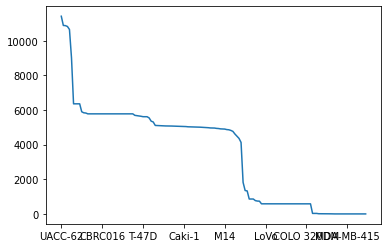

In [31]:
df_synergxdb.sampleName.value_counts().plot()

(-2.0, 2.0)

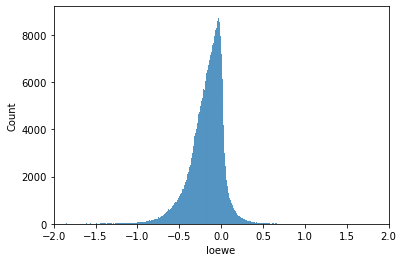

In [32]:
ax = sns.histplot(df_synergxdb.loewe)
ax.set_xlim(-2, 2)

In [33]:
df_synergxdb.loewe.isna().value_counts()

False    531659
True        320
Name: loewe, dtype: int64

(-3.0, 1.0)

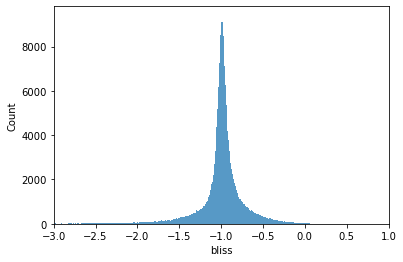

In [34]:
ax = sns.histplot(df_synergxdb.bliss)
ax.set_xlim(-3, 1)

In [35]:
df_synergxdb.bliss.isna().value_counts()

False    531762
True        217
Name: bliss, dtype: int64

(-3.0, 1.0)

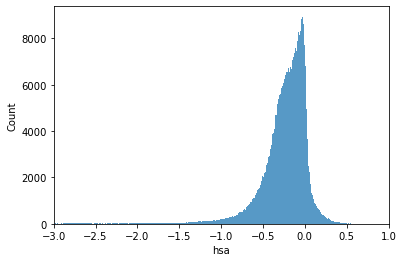

In [36]:
ax = sns.histplot(df_synergxdb.hsa)
ax.set_xlim(-3, 1)

In [37]:
df_synergxdb.hsa.isna().value_counts()

False    531762
True        217
Name: hsa, dtype: int64

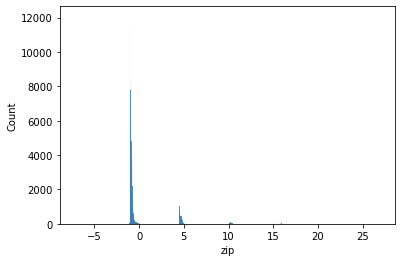

In [38]:
ax = sns.histplot(df_synergxdb.zip)
# ax.set_xlim(-3, 1)

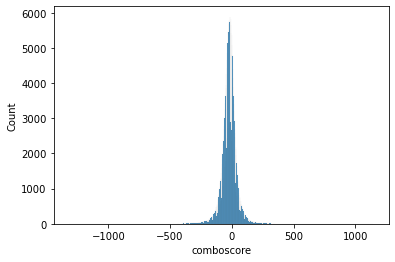

In [39]:
ax = sns.histplot(df_synergxdb.comboscore)


In [40]:
len(df_synergxdb[~df_synergxdb.comboscore.isna()])

296720

### RMA

In [41]:
df_l1000 = pd.read_csv('../data/synergxdb/RMA/L1000genes.txt', sep='\t')
df_l1000

,Entrez ID,Symbol,Name,Gene Family,Type,RNA-Seq Correlation,RNA-Seq Correlation Self-Rank
0,285550,FAM200B,family with sequence similarity 200 member B,NaN,not inferred,NaN,NaN
1,107985226,LOC107985226,uncharacterized LOC107985226,NaN,not inferred,NaN,NaN
2,285555,STPG2,sperm tail PG-rich repeat containing 2,NaN,not inferred,NaN,NaN
3,3640,INSL3,insulin like 3,Endogenous ligands,best inferred,0.55,0.00
4,285556,LOC285556,uncharacterized LOC285556,NaN,not inferred,NaN,NaN
...,...,...,...,...,...,...,...
20859,4953,ODC1,ornithine decarboxylase 1,NaN,best inferred,0.73,0.00
20860,3628,INPP1,inositol polyphosphate-1-phosphatase,Phosphoinositide phosphatases,landmark,NaN,NaN
20861,4956,ODF1,outer dense fiber of sperm tails 1,Small heat shock proteins,inferred,-0.04,0.57
20862,3627,CXCL10,C-X-C motif chemokine ligand 10,"Chemokine ligands, Endogenous ligands",best inferred,0.46,0.01


In [42]:
df_l1000_lm = df_l1000[df_l1000.Type == "landmark"]
lm_genes = list(df_l1000_lm.Symbol)
len(lm_genes)

978

In [43]:
# df_cell_list = pd.read_csv('../data/synergxdb/RMA/Cell_listFri Jan 14 19_13_29 2022.tsv', sep='\t')
# df_cell_list = df_cell_list[df_cell_list.Dataset == "GDSC1"]
# df_cell_list = df_cell_list.astype({"COSMIC_ID":str})
# df_cell_list

In [44]:
df_rma = pd.read_csv('../data/synergxdb/RMA/Cell_line_RMA_proc_basalExp.txt', sep='\t')
df_rma

,GENE_SYMBOLS,GENE_title,DATA.906826,DATA.687983,DATA.910927,DATA.1240138,DATA.1240139,DATA.906792,DATA.910688,DATA.1240135,...,DATA.753584,DATA.907044,DATA.998184,DATA.908145,DATA.1659787,DATA.1298157,DATA.1480372,DATA.1298533,DATA.930299,DATA.905954.1
0,TSPAN6,tetraspanin 6 [Source:HGNC Symbol;Acc:11858],7.632023,7.548671,8.712338,7.797142,7.729268,7.074533,3.285198,6.961606,...,7.105637,3.236503,3.038892,8.373223,6.932178,8.441628,8.422922,8.089255,3.112333,7.153127
1,TNMD,tenomodulin [Source:HGNC Symbol;Acc:17757],2.964585,2.777716,2.643508,2.817923,2.957739,2.889677,2.828203,2.874751,...,2.798847,2.745137,2.976406,2.852552,2.622630,2.639276,2.879890,2.521169,2.870468,2.834285
2,DPM1,dolichyl-phosphate mannosyltransferase polypep...,10.379553,11.807341,9.880733,9.883471,10.418840,9.773987,10.264385,10.205931,...,10.486486,10.442951,10.311962,10.454830,10.418475,11.463742,10.557777,10.792750,9.873902,10.788218
3,SCYL3,SCY1-like 3 (S. cerevisiae) [Source:HGNC Symbo...,3.614794,4.066887,3.956230,4.063701,4.341500,4.270903,5.968168,3.715033,...,3.696835,4.624013,4.348524,3.858121,3.947561,4.425849,3.550390,4.443337,4.266828,4.100493
4,C1orf112,chromosome 1 open reading frame 112 [Source:HG...,3.380681,3.732485,3.236620,3.558414,3.840373,3.815055,3.011867,3.268449,...,3.726833,3.947744,3.806584,3.196988,3.814831,4.384732,4.247189,3.071359,3.230197,3.435795
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17732,NaN,hsa-mir-5195 [Source:miRBase;Acc:MI0018174],2.852537,2.776771,2.685307,3.436412,2.951270,3.233383,3.810246,2.792116,...,2.699663,5.190438,3.253381,3.000088,2.846830,2.959009,2.974475,2.903894,2.857956,3.033662
17733,POLRMTP1,polymerase (RNA) mitochondrial (DNA directed) ...,3.130696,3.260982,3.176239,3.074432,3.213545,3.382112,3.200106,2.829053,...,2.773728,2.988250,3.514337,3.254306,3.139208,3.007502,3.088841,2.847505,2.832840,2.817057
17734,UBL5P2,ubiquitin-like 5 pseudogene 2 [Source:HGNC Sym...,9.986616,9.002814,9.113243,9.958284,9.938978,8.714820,9.396484,9.779745,...,9.593772,9.506062,9.945730,9.890244,10.018968,9.332193,10.742651,8.544696,9.900550,9.071943
17735,TBC1D3P5,"TBC1 domain family, member 3 pseudogene 5 [Sou...",3.073724,3.000182,2.916274,3.256500,3.396126,3.497439,3.193505,3.254539,...,3.407260,3.256900,3.189972,3.155584,3.357660,3.435411,3.317945,3.174515,3.243563,3.324517


In [45]:
# print(list(df_rma.columns))

In [46]:
set(["DATA."+str(c) for c in cosmic_found]).difference(set(df_rma.columns))

{'DATA.905943', 'DATA.906825'}

In [47]:
cosmic_intersect = list(set(["DATA."+str(c) for c in cosmic_found]).intersection(set(df_rma.columns)))
len(cosmic_intersect)

95

In [48]:
# df_rma[cosmic_intersect]

In [49]:
df_cosmic_found_intersect = df_cosmic_found[df_cosmic_found.Cosmic_ID.isin([int(c[len("DATA."):]) for c in cosmic_intersect])]
df_cosmic_found_intersect

,sampleName,idCellosaurus,count,Cosmic_ID
0,UACC-62,CVCL_1780,11413,905976.0
1,UACC-257,CVCL_1779,10881,905977.0
2,SK-MEL-28,CVCL_0526,10872,905954.0
3,SK-MEL-5,CVCL_0527,10823,905956.0
4,LOX-IMVI,CVCL_1381,10650,905974.0
5,SK-MEL-2,CVCL_0069,9004,905955.0
6,SK-MEL-30,CVCL_0039,6357,909726.0
7,A-375,CVCL_0132,6357,906793.0
8,RPMI-7951,CVCL_1666,6357,910903.0
9,A2058,CVCL_1059,6357,906792.0


In [50]:
dict_cosmic_found_intersect = dict(zip(df_cosmic_found_intersect.sampleName, df_cosmic_found_intersect.Cosmic_ID.astype('int')))

In [51]:
df_synergxdb_filter = df_synergxdb[df_synergxdb.sampleName.isin(df_cosmic_found_intersect.sampleName)]
df_synergxdb_filter

,Unnamed: 0,comboId,idSample,bliss,loewe,hsa,zip,comboscore,sourceName,sampleName,...,atCodeDrugA,idDrugBankA,idPubChemDrugA,atCodeDrugB,idDrugBankB,idPubChemDrugB,smilesDrugA,inchikeyDrugA,smilesDrugB,inchikeyDrugB
4,4,592303,94,-0.3512,-0.2331,-0.3563,-0.1433,NaN,VISAGE,BT-20,...,NaN,NaN,73389731.0,NaN,NaN,11364421.0,C1CC1NC2=NC(=NC(=C2)C3=C(C(=CC=C3)Cl)Cl)N,PNMYJIOQIAEYQL-UHFFFAOYSA-N,CCC1C(=O)N(C2=CN=C(N=C2N1C3CCCC3)NC4=C(C=C(C=C...,XQVVPGYIWAGRNI-JOCHJYFZSA-N
6,6,592301,5,-0.3144,-0.0021,-0.2713,-0.1511,NaN,VISAGE,A-549,...,NaN,NaN,73389731.0,NaN,NaN,11364421.0,C1CC1NC2=NC(=NC(=C2)C3=C(C(=CC=C3)Cl)Cl)N,PNMYJIOQIAEYQL-UHFFFAOYSA-N,CCC1C(=O)N(C2=CN=C(N=C2N1C3CCCC3)NC4=C(C=C(C=C...,XQVVPGYIWAGRNI-JOCHJYFZSA-N
8,8,592310,116,-0.4068,-0.0116,-0.3765,-0.1640,NaN,VISAGE,HCC38,...,NaN,NaN,73389731.0,NaN,NaN,11364421.0,C1CC1NC2=NC(=NC(=C2)C3=C(C(=CC=C3)Cl)Cl)N,PNMYJIOQIAEYQL-UHFFFAOYSA-N,CCC1C(=O)N(C2=CN=C(N=C2N1C3CCCC3)NC4=C(C=C(C=C...,XQVVPGYIWAGRNI-JOCHJYFZSA-N
10,10,592311,20,-0.4182,0.0114,-0.4363,-0.1725,NaN,VISAGE,HCT 116,...,NaN,NaN,73389731.0,NaN,NaN,11364421.0,C1CC1NC2=NC(=NC(=C2)C3=C(C(=CC=C3)Cl)Cl)N,PNMYJIOQIAEYQL-UHFFFAOYSA-N,CCC1C(=O)N(C2=CN=C(N=C2N1C3CCCC3)NC4=C(C=C(C=C...,XQVVPGYIWAGRNI-JOCHJYFZSA-N
15,15,592328,7,-0.3957,-0.0891,-0.3105,-0.1973,NaN,VISAGE,PC-3,...,NaN,NaN,73389731.0,NaN,NaN,11364421.0,C1CC1NC2=NC(=NC(=C2)C3=C(C(=CC=C3)Cl)Cl)N,PNMYJIOQIAEYQL-UHFFFAOYSA-N,CCC1C(=O)N(C2=CN=C(N=C2N1C3CCCC3)NC4=C(C=C(C=C...,XQVVPGYIWAGRNI-JOCHJYFZSA-N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
530643,22708,6178,28,-1.3161,NaN,-0.3261,NaN,NaN,MERCK,MDA-MB-468,...,A10BA02;A10BD13;A10BD18;A10BD02;A10BD03;A10BD1...,DB00331,4091.0,L01XE05,DB00398,216239.0,CN(C)C(=N)N=C(N)N,XZWYZXLIPXDOLR-UHFFFAOYSA-N,CNC(=O)C1=NC=CC(=C1)OC2=CC=C(C=C2)NC(=O)NC3=CC...,MLDQJTXFUGDVEO-UHFFFAOYSA-N
530644,22709,6403,28,-1.1085,NaN,-0.1568,NaN,NaN,MERCK,MDA-MB-468,...,L01AX03,DB00853,5394.0,NaN,DB07101,9826528.0,CN1C(=O)N2C=NC(=C2N=N1)C(=O)N,BPEGJWRSRHCHSN-UHFFFAOYSA-N,C1=CC(=C(C=C1I)F)NC2=C(C=CC(=C2F)F)C(=O)NOCC(CO)O,SUDAHWBOROXANE-SECBINFHSA-N
530649,22714,8141,31,-1.4620,NaN,-0.5846,NaN,NaN,MERCK,PA-1,...,L01AX03,DB00853,5394.0,L01XX32,DB00188,387447.0,CN1C(=O)N2C=NC(=C2N=N1)C(=O)N,BPEGJWRSRHCHSN-UHFFFAOYSA-N,B(C(CC(C)C)NC(=O)C(CC1=CC=CC=C1)NC(=O)C2=NC=CN...,GXJABQQUPOEUTA-RDJZCZTQSA-N
530650,22715,8145,31,-1.4753,NaN,-0.5979,NaN,NaN,MERCK,PA-1,...,L01AX03,DB00853,5394.0,NaN,DB12021,46926350.0,CN1C(=O)N2C=NC(=C2N=N1)C(=O)N,BPEGJWRSRHCHSN-UHFFFAOYSA-N,CCC1=C2N=C(C=C(N2N=C1)NCC3=C[N+](=CC=C3)[O-])N...,PIMQWRZWLQKKBJ-SFHVURJKSA-N


In [52]:
df_synergxdb_filter.sourceName.value_counts()

NCI-ALMANAC     266802
MIT-MELANOMA    138118
MERCK            17470
YALE-TNBC         4573
STANFORD          1818
YALE-PDAC         1604
DECREASE            54
VISAGE              14
Name: sourceName, dtype: int64

In [53]:
list_scores = ["bliss", "loewe", "hsa"]

In [54]:
for score in list_scores:
    print(score)
    print(df_synergxdb_filter[score].isna().value_counts())

bliss
False    430248
True        205
Name: bliss, dtype: int64
loewe
False    430200
True        253
Name: loewe, dtype: int64
hsa
False    430248
True        205
Name: hsa, dtype: int64


In [55]:
df_synergxdb_filter[list_scores].notna().all(axis=1)

4          True
6          True
8          True
10         True
15         True
          ...  
530643    False
530644    False
530649    False
530650    False
530651    False
Length: 430453, dtype: bool

In [56]:
df_synergxdb_filter = df_synergxdb_filter.loc[df_synergxdb_filter[list_scores].notna().all(axis=1)]
df_synergxdb_filter

,Unnamed: 0,comboId,idSample,bliss,loewe,hsa,zip,comboscore,sourceName,sampleName,...,atCodeDrugA,idDrugBankA,idPubChemDrugA,atCodeDrugB,idDrugBankB,idPubChemDrugB,smilesDrugA,inchikeyDrugA,smilesDrugB,inchikeyDrugB
4,4,592303,94,-0.3512,-0.2331,-0.3563,-0.1433,NaN,VISAGE,BT-20,...,NaN,NaN,73389731.0,NaN,NaN,11364421.0,C1CC1NC2=NC(=NC(=C2)C3=C(C(=CC=C3)Cl)Cl)N,PNMYJIOQIAEYQL-UHFFFAOYSA-N,CCC1C(=O)N(C2=CN=C(N=C2N1C3CCCC3)NC4=C(C=C(C=C...,XQVVPGYIWAGRNI-JOCHJYFZSA-N
6,6,592301,5,-0.3144,-0.0021,-0.2713,-0.1511,NaN,VISAGE,A-549,...,NaN,NaN,73389731.0,NaN,NaN,11364421.0,C1CC1NC2=NC(=NC(=C2)C3=C(C(=CC=C3)Cl)Cl)N,PNMYJIOQIAEYQL-UHFFFAOYSA-N,CCC1C(=O)N(C2=CN=C(N=C2N1C3CCCC3)NC4=C(C=C(C=C...,XQVVPGYIWAGRNI-JOCHJYFZSA-N
8,8,592310,116,-0.4068,-0.0116,-0.3765,-0.1640,NaN,VISAGE,HCC38,...,NaN,NaN,73389731.0,NaN,NaN,11364421.0,C1CC1NC2=NC(=NC(=C2)C3=C(C(=CC=C3)Cl)Cl)N,PNMYJIOQIAEYQL-UHFFFAOYSA-N,CCC1C(=O)N(C2=CN=C(N=C2N1C3CCCC3)NC4=C(C=C(C=C...,XQVVPGYIWAGRNI-JOCHJYFZSA-N
10,10,592311,20,-0.4182,0.0114,-0.4363,-0.1725,NaN,VISAGE,HCT 116,...,NaN,NaN,73389731.0,NaN,NaN,11364421.0,C1CC1NC2=NC(=NC(=C2)C3=C(C(=CC=C3)Cl)Cl)N,PNMYJIOQIAEYQL-UHFFFAOYSA-N,CCC1C(=O)N(C2=CN=C(N=C2N1C3CCCC3)NC4=C(C=C(C=C...,XQVVPGYIWAGRNI-JOCHJYFZSA-N
15,15,592328,7,-0.3957,-0.0891,-0.3105,-0.1973,NaN,VISAGE,PC-3,...,NaN,NaN,73389731.0,NaN,NaN,11364421.0,C1CC1NC2=NC(=NC(=C2)C3=C(C(=CC=C3)Cl)Cl)N,PNMYJIOQIAEYQL-UHFFFAOYSA-N,CCC1C(=O)N(C2=CN=C(N=C2N1C3CCCC3)NC4=C(C=C(C=C...,XQVVPGYIWAGRNI-JOCHJYFZSA-N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
530591,22656,16328,69,-1.5349,-0.5449,-0.5449,-0.9900,NaN,MERCK,RPMI-7951,...,NaN,DB07232,11960529.0,NaN,DB11651,11977753.0,CC1(CCCN1)C2=NC3=C(C=CC=C3N2)C(=O)N,JNAHVYVRKWKWKQ-CYBMUJFWSA-N,CC(C)(C#N)C1=CC=C(C=C1)N2C3=C4C=C(C=CC4=NC=C3N...,JOGKUKXHTYWRGZ-UHFFFAOYSA-N
530592,22657,16330,69,-1.3686,-0.3786,-0.3786,-0.9900,NaN,MERCK,RPMI-7951,...,NaN,DB07232,11960529.0,L01XE19,DB06233,11520894.0,CC1(CCCN1)C2=NC3=C(C=CC=C3N2)C(=O)N,JNAHVYVRKWKWKQ-CYBMUJFWSA-N,CC1CCC2CC(C(=CC=CC=CC(CC(C(=O)C(C(C(=CC(C(=O)C...,BUROJSBIWGDYCN-GAUTUEMISA-N
530593,22658,16331,69,-1.2745,-0.2845,-0.2845,-0.9900,NaN,MERCK,RPMI-7951,...,NaN,DB07232,11960529.0,NaN,DB05482,104842.0,CC1(CCCN1)C2=NC3=C(C=CC=C3N2)C(=O)N,JNAHVYVRKWKWKQ-CYBMUJFWSA-N,CCC1=C2CN3C(=CC4=C(C3=O)COC(=O)C4(CC)O)C2=NC5=...,FJHBVJOVLFPMQE-QFIPXVFZSA-N
530594,22659,16332,69,-1.3666,-0.3766,-0.3766,-0.9900,NaN,MERCK,RPMI-7951,...,NaN,DB07232,11960529.0,L01XE05,DB00398,216239.0,CC1(CCCN1)C2=NC3=C(C=CC=C3N2)C(=O)N,JNAHVYVRKWKWKQ-CYBMUJFWSA-N,CNC(=O)C1=NC=CC(=C1)OC2=CC=C(C=C2)NC(=O)NC3=CC...,MLDQJTXFUGDVEO-UHFFFAOYSA-N


In [57]:
df_synergxdb_filter.columns

Index(['Unnamed: 0', 'comboId', 'idSample', 'bliss', 'loewe', 'hsa', 'zip',
       'comboscore', 'sourceName', 'sampleName', 'drugNameA', 'drugNameB',
       'tissue', 'idSource', 'idDrugA', 'idDrugB', 'idCellosaurus', 'sex',
       'age', 'disease', 'origin', 'atCodeDrugA', 'idDrugBankA',
       'idPubChemDrugA', 'atCodeDrugB', 'idDrugBankB', 'idPubChemDrugB',
       'smilesDrugA', 'inchikeyDrugA', 'smilesDrugB', 'inchikeyDrugB'],
      dtype='object')

In [58]:
df_synergxdb_filter["zloewe"] = stats.zscore(df_synergxdb_filter.loewe)
df_synergxdb_filter["zbliss"] = stats.zscore(df_synergxdb_filter.bliss)
df_synergxdb_filter["zhsa"] = stats.zscore(df_synergxdb_filter.hsa)

In [59]:
n_parts = 10

In [60]:
q_labels = [0] + list(range(-1, -n_parts +1, -1)) + [1]
q_labels

[0, -1, -2, -3, -4, -5, -6, -7, -8, 1]

In [61]:
zloewe_quart = pd.qcut(df_synergxdb_filter.zloewe, n_parts, labels=q_labels).astype(int)
zbliss_quart = pd.qcut(df_synergxdb_filter.zbliss, n_parts, labels=q_labels).astype(int)
zhsa_quart = pd.qcut(df_synergxdb_filter.zhsa, n_parts, labels=q_labels).astype(int)

In [62]:
df_synergxdb_filter[zloewe_quart == 0].index

Int64Index([    41,     44,     45,     48,     49,     51,     53,     55,
                58,     61,
            ...
            530580, 530581, 530582, 530586, 530587, 530588, 530589, 530590,
            530591, 530595],
           dtype='int64', length=43021)

In [63]:
idx_zloewe_zhsa_0 = set(df_synergxdb_filter[zloewe_quart == 0].index).intersection(set(df_synergxdb_filter[zhsa_quart == 0].index))
idx_zloewe_zhsa_1 = set(df_synergxdb_filter[zloewe_quart == 1].index).intersection(set(df_synergxdb_filter[zhsa_quart == 1].index))

In [64]:
len(set(df_synergxdb_filter[zbliss_quart == 1].index).intersection(
    set(df_synergxdb_filter[zhsa_quart == 1].index)))

20932

In [65]:
df_synergxdb_filter.loc[idx_zloewe_zhsa_1].zloewe.min()

0.40649603121219763

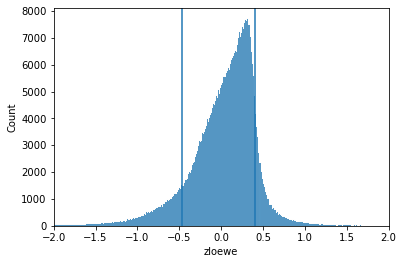

In [66]:
ax = sns.histplot(df_synergxdb_filter.zloewe)
ax.set_xlim(-2, 2)
plt.axvline(df_synergxdb_filter[zloewe_quart == 0].zloewe.max(), 0, 1.0)
plt.axvline(df_synergxdb_filter[zloewe_quart == 1].zloewe.min(), 0, 1.0)

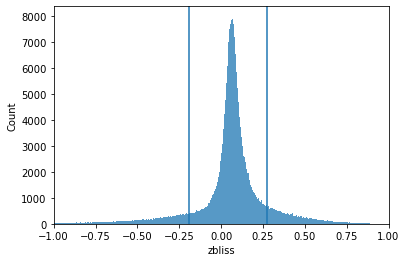

In [67]:
ax = sns.histplot(df_synergxdb_filter.zbliss)
ax.set_xlim(-1, 1)
plt.axvline(df_synergxdb_filter[zbliss_quart == 0].zbliss.max(), 0, 1.0)
plt.axvline(df_synergxdb_filter[zbliss_quart == 1].zbliss.min(), 0, 1.0)

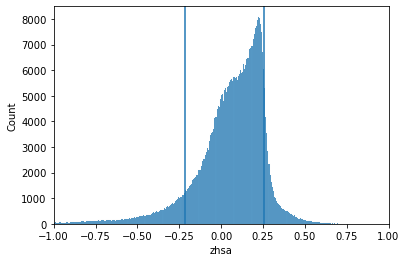

In [68]:
ax = sns.histplot(df_synergxdb_filter.zhsa)
ax.set_xlim(-1, 1)
plt.axvline(df_synergxdb_filter[zhsa_quart == 0].zhsa.max(), 0, 1.0)
plt.axvline(df_synergxdb_filter[zhsa_quart == 1].zhsa.min(), 0, 1.0)

In [69]:
zloewe_quart[zloewe_quart >= 0]

41        0
44        0
45        0
48        0
49        0
         ..
530588    0
530589    0
530590    0
530591    0
530595    0
Name: zloewe, Length: 86027, dtype: int64

In [70]:
df_synergxdb_filter_zloewe = df_synergxdb_filter[zloewe_quart >= 0].copy()
df_synergxdb_filter_zloewe["labzloe"] = zloewe_quart[zloewe_quart >= 0]#.astype(str)
df_synergxdb_filter_zloewe

,Unnamed: 0,comboId,idSample,bliss,loewe,hsa,zip,comboscore,sourceName,sampleName,...,idDrugBankB,idPubChemDrugB,smilesDrugA,inchikeyDrugA,smilesDrugB,inchikeyDrugB,zloewe,zbliss,zhsa,labzloe
41,7,123291,23,-0.9131,-0.4482,-0.4483,21.4188,14.0,NCI-ALMANAC,HT-29,...,DB00544,3385.0,CC1=C(C(CCC1)(C)C)C=CC(=CC=CC(=CC(=O)O)C)C,SHGAZHPCJJPHSC-YCNIQYBTSA-N,C1=C(C(=O)NC(=O)N1)F,GHASVSINZRGABV-UHFFFAOYSA-N,-0.521972,0.127095,-0.119948,0
44,10,140331,2,-0.9981,-0.6077,-0.6158,21.4078,-16.0,NCI-ALMANAC,MOLT-4,...,DB00791,6194.0,CN(C)C1=NC(=NC(=N1)N(C)C)N(C)C,UUVWYPNAQBNQJQ-UHFFFAOYSA-N,C1=C(C(=O)NC(=O)N1)N(CCCl)CCCl,IDPUKCWIGUEADI-UHFFFAOYSA-N,-0.839968,0.057031,-0.258088,0
45,11,110914,20,-0.9538,-0.5403,-0.5358,21.4052,-24.0,NCI-ALMANAC,HCT 116,...,DB00544,3385.0,C1=CC(=CC=C1C#N)C(C2=CC=C(C=C2)C#N)N3C=NC=N3,HPJKCIUCZWXJDR-UHFFFAOYSA-N,C1=C(C(=O)NC(=O)N1)F,GHASVSINZRGABV-UHFFFAOYSA-N,-0.705592,0.093547,-0.192110,0
48,14,89302,15,-1.0869,-0.6541,-0.6506,21.3856,71.0,NCI-ALMANAC,CCRF-CEM,...,DB00444,452548.0,CC1=C(C(=CC=C1)Cl)NC(=O)C2=CN=C(S2)NC3=CC(=NC(...,ZBNZXTGUTAYRHI-UHFFFAOYSA-N,COC1=CC(=CC(=C1O)OC)C2C3C(COC3=O)C(C4=CC5=C(C=...,NRUKOCRGYNPUPR-QBPJDGROSA-N,-0.932476,-0.016166,-0.286788,0
49,15,89999,15,-0.9852,-0.5196,-0.5491,21.3803,9.0,NCI-ALMANAC,CCRF-CEM,...,DB05294,3081361.0,CC1OCC2C(O1)C(C(C(O2)OC3C4COC(=O)C4C(C5=CC6=C(...,VJJPUSNTGOMMGY-MRVIYFEKSA-N,CN1CCC(CC1)COC2=C(C=C3C(=C2)N=CN=C3NC4=C(C=C(C...,UHTHHESEBZOYNR-UHFFFAOYSA-N,-0.664323,0.067664,-0.203079,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
530588,22653,16325,69,-1.4846,-0.4946,-0.4946,-0.9900,NaN,MERCK,RPMI-7951,...,DB11899,16224745.0,CC1(CCCN1)C2=NC3=C(C=CC=C3N2)C(=O)N,JNAHVYVRKWKWKQ-CYBMUJFWSA-N,CN1C=C(C=N1)C2=C3N=C(C(=C(N3N=C2)N)Br)C4CCCNC4,GMIZZEXBPRLVIV-UHFFFAOYSA-N,-0.614480,-0.343987,-0.158132,0
530589,22654,16326,69,-1.4654,-0.4754,-0.4754,-0.9900,NaN,MERCK,RPMI-7951,...,DB12021,46926350.0,CC1(CCCN1)C2=NC3=C(C=CC=C3N2)C(=O)N,JNAHVYVRKWKWKQ-CYBMUJFWSA-N,CCC1=C2N=C(C=C(N2N=C1)NCC3=C[N+](=CC=C3)[O-])N...,PIMQWRZWLQKKBJ-SFHVURJKSA-N,-0.576201,-0.328160,-0.142297,0
530590,22655,16327,69,-1.6869,-0.6969,-0.6969,-0.9900,NaN,MERCK,RPMI-7951,...,DB02424,5288382.0,CC1(CCCN1)C2=NC3=C(C=CC=C3N2)C(=O)N,JNAHVYVRKWKWKQ-CYBMUJFWSA-N,CC1CC(C(C(C=C(C(C(C=CC=C(C(=O)NC2=CC(=O)C(=C(C...,QTQAWLPCGQOSGP-KSRBKZBZSA-N,-1.017807,-0.510741,-0.324972,0
530591,22656,16328,69,-1.5349,-0.5449,-0.5449,-0.9900,NaN,MERCK,RPMI-7951,...,DB11651,11977753.0,CC1(CCCN1)C2=NC3=C(C=CC=C3N2)C(=O)N,JNAHVYVRKWKWKQ-CYBMUJFWSA-N,CC(C)(C#N)C1=CC=C(C=C1)N2C3=C4C=C(C=CC4=NC=C3N...,JOGKUKXHTYWRGZ-UHFFFAOYSA-N,-0.714764,-0.385449,-0.199615,0


In [71]:
df_synergxdb_dedup = df_synergxdb_filter_zloewe.copy()
# df_synergxdb_dedup
df_synergxdb_dedup = df_synergxdb_dedup.astype({"labzloe": str})
cols = ['drugNameA', 'drugNameB', "sampleName"]
df_synergxdb_dedup[cols] = np.sort(df_synergxdb_dedup[cols].values, axis=1)
dup = df_synergxdb_dedup.duplicated(subset=cols, keep=False)
# cols += ["labzloe"]
# df_synergxdb_dedup[cols] = np.sort(df_synergxdb_dedup[cols].values, axis=1)
# dup_lab = df_synergxdb_dedup.duplicated(subset=cols, keep=False)

In [72]:
dup_lab = df_synergxdb_dedup[dup][cols+ ["labzloe"]].sort_values(cols).duplicated(keep=False)#.value_counts()
dup_lab

10327      True
48717      True
221945     True
240402     True
179119     True
          ...  
514207    False
456952    False
511680    False
469950    False
514043    False
Length: 1245, dtype: bool

In [73]:
df_synergxdb_dedup[dup][cols+ ["labzloe"]].sort_values(cols)[~dup_lab]

,drugNameA,drugNameB,sampleName,labzloe
343810,A-375,Adavosertib,Gemcitabine,0
509028,A-375,Adavosertib,Gemcitabine,1
313938,A-375,Bortezomib,Dactolisib,0
512424,A-375,Bortezomib,Dactolisib,1
310889,A-375,Bortezomib,Erlotinib,1
...,...,...,...,...
514207,Sunitinib,UACC-62,Vorinostat,1
456952,Temozolomide,UACC-62,Vorinostat,0
511680,Temozolomide,UACC-62,Vorinostat,1
469950,UACC-62,Veliparib,Vorinostat,0


In [74]:
df_synergxdb_filter[cols+ ["zloewe", "sourceName"]].loc[dup_lab[~dup_lab].index]

,drugNameA,drugNameB,sampleName,zloewe,sourceName
343810,Gemcitabine,Adavosertib,A-375,-0.619265,MIT-MELANOMA
509028,Gemcitabine,Adavosertib,A-375,0.513558,MERCK
313938,Dactolisib,Bortezomib,A-375,-0.501038,MIT-MELANOMA
512424,Bortezomib,Dactolisib,A-375,0.743033,MERCK
310889,Bortezomib,Erlotinib,A-375,0.410085,MIT-MELANOMA
...,...,...,...,...,...
514207,Vorinostat,Sunitinib,UACC-62,0.888175,MERCK
456952,Temozolomide,Vorinostat,UACC-62,-0.879444,MIT-MELANOMA
511680,Vorinostat,Temozolomide,UACC-62,1.323002,MERCK
469950,Veliparib,Vorinostat,UACC-62,-1.414355,MIT-MELANOMA


In [75]:
df_synergxdb_filter_zloewe = df_synergxdb_filter_zloewe.drop(index=dup_lab[~dup_lab].index)

In [76]:
df_synergxdb_filter_zloewe

,Unnamed: 0,comboId,idSample,bliss,loewe,hsa,zip,comboscore,sourceName,sampleName,...,idDrugBankB,idPubChemDrugB,smilesDrugA,inchikeyDrugA,smilesDrugB,inchikeyDrugB,zloewe,zbliss,zhsa,labzloe
41,7,123291,23,-0.9131,-0.4482,-0.4483,21.4188,14.0,NCI-ALMANAC,HT-29,...,DB00544,3385.0,CC1=C(C(CCC1)(C)C)C=CC(=CC=CC(=CC(=O)O)C)C,SHGAZHPCJJPHSC-YCNIQYBTSA-N,C1=C(C(=O)NC(=O)N1)F,GHASVSINZRGABV-UHFFFAOYSA-N,-0.521972,0.127095,-0.119948,0
44,10,140331,2,-0.9981,-0.6077,-0.6158,21.4078,-16.0,NCI-ALMANAC,MOLT-4,...,DB00791,6194.0,CN(C)C1=NC(=NC(=N1)N(C)C)N(C)C,UUVWYPNAQBNQJQ-UHFFFAOYSA-N,C1=C(C(=O)NC(=O)N1)N(CCCl)CCCl,IDPUKCWIGUEADI-UHFFFAOYSA-N,-0.839968,0.057031,-0.258088,0
45,11,110914,20,-0.9538,-0.5403,-0.5358,21.4052,-24.0,NCI-ALMANAC,HCT 116,...,DB00544,3385.0,C1=CC(=CC=C1C#N)C(C2=CC=C(C=C2)C#N)N3C=NC=N3,HPJKCIUCZWXJDR-UHFFFAOYSA-N,C1=C(C(=O)NC(=O)N1)F,GHASVSINZRGABV-UHFFFAOYSA-N,-0.705592,0.093547,-0.192110,0
48,14,89302,15,-1.0869,-0.6541,-0.6506,21.3856,71.0,NCI-ALMANAC,CCRF-CEM,...,DB00444,452548.0,CC1=C(C(=CC=C1)Cl)NC(=O)C2=CN=C(S2)NC3=CC(=NC(...,ZBNZXTGUTAYRHI-UHFFFAOYSA-N,COC1=CC(=CC(=C1O)OC)C2C3C(COC3=O)C(C4=CC5=C(C=...,NRUKOCRGYNPUPR-QBPJDGROSA-N,-0.932476,-0.016166,-0.286788,0
49,15,89999,15,-0.9852,-0.5196,-0.5491,21.3803,9.0,NCI-ALMANAC,CCRF-CEM,...,DB05294,3081361.0,CC1OCC2C(O1)C(C(C(O2)OC3C4COC(=O)C4C(C5=CC6=C(...,VJJPUSNTGOMMGY-MRVIYFEKSA-N,CN1CCC(CC1)COC2=C(C=C3C(=C2)N=CN=C3NC4=C(C=C(C...,UHTHHESEBZOYNR-UHFFFAOYSA-N,-0.664323,0.067664,-0.203079,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
530588,22653,16325,69,-1.4846,-0.4946,-0.4946,-0.9900,NaN,MERCK,RPMI-7951,...,DB11899,16224745.0,CC1(CCCN1)C2=NC3=C(C=CC=C3N2)C(=O)N,JNAHVYVRKWKWKQ-CYBMUJFWSA-N,CN1C=C(C=N1)C2=C3N=C(C(=C(N3N=C2)N)Br)C4CCCNC4,GMIZZEXBPRLVIV-UHFFFAOYSA-N,-0.614480,-0.343987,-0.158132,0
530589,22654,16326,69,-1.4654,-0.4754,-0.4754,-0.9900,NaN,MERCK,RPMI-7951,...,DB12021,46926350.0,CC1(CCCN1)C2=NC3=C(C=CC=C3N2)C(=O)N,JNAHVYVRKWKWKQ-CYBMUJFWSA-N,CCC1=C2N=C(C=C(N2N=C1)NCC3=C[N+](=CC=C3)[O-])N...,PIMQWRZWLQKKBJ-SFHVURJKSA-N,-0.576201,-0.328160,-0.142297,0
530590,22655,16327,69,-1.6869,-0.6969,-0.6969,-0.9900,NaN,MERCK,RPMI-7951,...,DB02424,5288382.0,CC1(CCCN1)C2=NC3=C(C=CC=C3N2)C(=O)N,JNAHVYVRKWKWKQ-CYBMUJFWSA-N,CC1CC(C(C(C=C(C(C(C=CC=C(C(=O)NC2=CC(=O)C(=C(C...,QTQAWLPCGQOSGP-KSRBKZBZSA-N,-1.017807,-0.510741,-0.324972,0
530591,22656,16328,69,-1.5349,-0.5449,-0.5449,-0.9900,NaN,MERCK,RPMI-7951,...,DB11651,11977753.0,CC1(CCCN1)C2=NC3=C(C=CC=C3N2)C(=O)N,JNAHVYVRKWKWKQ-CYBMUJFWSA-N,CC(C)(C#N)C1=CC=C(C=C1)N2C3=C4C=C(C=CC4=NC=C3N...,JOGKUKXHTYWRGZ-UHFFFAOYSA-N,-0.714764,-0.385449,-0.199615,0


In [77]:
df_synergxdb_dedup = df_synergxdb_filter_zloewe.copy()
# df_synergxdb_dedup
df_synergxdb_dedup = df_synergxdb_dedup.astype({"labzloe": str})
cols = ['drugNameA', 'drugNameB', "sampleName"]
df_synergxdb_dedup[cols] = np.sort(df_synergxdb_dedup[cols].values, axis=1)
dup = df_synergxdb_dedup.duplicated(subset=cols+["labzloe"], keep='first')

In [78]:
dup.value_counts()

False    85262
True       481
dtype: int64

In [79]:
df_synergxdb_dedup[dup]

,Unnamed: 0,comboId,idSample,bliss,loewe,hsa,zip,comboscore,sourceName,sampleName,...,idDrugBankB,idPubChemDrugB,smilesDrugA,inchikeyDrugA,smilesDrugB,inchikeyDrugB,zloewe,zbliss,zhsa,labzloe
468,434,115294,21,-0.9823,-0.5216,-0.5032,15.8494,-8.0,NCI-ALMANAC,Vemurafenib,...,DB08881,42611257.0,C1=C(C(=O)NC(=O)N1)F,GHASVSINZRGABV-UHFFFAOYSA-N,CCCS(=O)(=O)NC1=C(C(=C(C=C1)F)C(=O)C2=CNC3=C2C...,GPXBXXGIAQBQNI-UHFFFAOYSA-N,-0.668310,0.070054,-0.165225,0
826,792,249774,55,-1.0416,-0.4511,-0.4448,15.7634,-2.0,NCI-ALMANAC,Vemurafenib,...,DB05294,3081361.0,CCCS(=O)(=O)NC1=C(C(=C(C=C1)F)C(=O)C2=CNC3=C2C...,GPXBXXGIAQBQNI-UHFFFAOYSA-N,CN1CCC(CC1)COC2=C(C=C3C(=C2)N=CN=C3NC4=C(C=C(C...,UHTHHESEBZOYNR-UHFFFAOYSA-N,-0.527754,0.021174,-0.117061,0
1999,1965,146569,30,-0.9775,-0.4734,-0.4999,10.3788,81.0,NCI-ALMANAC,Vandetanib,...,DB05294,3081361.0,CC1=C2C(C(=O)C3(C(CC4C(C3C(C(C2(C)C)(CC1OC(=O)...,BMQGVNUXMIRLCK-OAGWZNDDSA-N,CN1CCC(CC1)COC2=C(C=C3C(=C2)N=CN=C3NC4=C(C=C(C...,UHTHHESEBZOYNR-UHFFFAOYSA-N,-0.572214,0.074011,-0.162503,0
2538,2504,207051,47,-1.0980,-0.6230,-0.6229,10.3305,102.0,NCI-ALMANAC,Cabazitaxel,...,DB06626,6450551.0,CC1=C2C(C(=O)C3(C(CC4C(C3C(C(C2(C)C)(CC1OC(=O)...,BMQGVNUXMIRLCK-OAGWZNDDSA-N,CNC(=O)C1=CC=CC=C1SC2=CC3=C(C=C2)C(=NN3)C=CC4=...,RITAVMQDGBJQJZ-FMIVXFBMSA-N,-0.870472,-0.025316,-0.263943,0
2564,2530,124138,24,-1.0127,-0.5575,-0.5580,10.3279,-92.0,NCI-ALMANAC,Hs 578T,...,DB06772,9854073.0,CC(C1=C(C=CC(=C1Cl)F)Cl)OC2=C(N=CC(=C2)C3=CN(N...,KTEIFNKAUNYNJU-GFCCVEGCSA-N,CC1=C2C(C(=O)C3(C(CC4C(C3C(C(C2(C)C)(CC1OC(=O)...,BMQGVNUXMIRLCK-OAGWZNDDSA-N,-0.739884,0.044996,-0.210419,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
528659,20724,3132,20,-1.5116,-0.5216,-0.5216,-0.9869,NaN,MERCK,HCT 116,...,DB00188,387447.0,COCCOC1=C(C=C2C(=C1)C(=NC=N2)NC3=CC=CC(=C3)C#C...,AAKJLRGGTJKAMG-UHFFFAOYSA-N,B(C(CC(C)C)NC(=O)C(CC1=CC=CC=C1)NC(=O)C2=NC=CN...,GXJABQQUPOEUTA-RDJZCZTQSA-N,-0.668310,-0.366243,-0.180399,0
528791,20856,17498,80,-1.5281,-0.5381,-0.5381,-0.9878,NaN,MERCK,Veliparib,...,DB00398,216239.0,CC1(CCCN1)C2=NC3=C(C=CC=C3N2)C(=O)N,JNAHVYVRKWKWKQ-CYBMUJFWSA-N,CNC(=O)C1=NC=CC(=C1)OC2=CC=C(C=C2)NC(=O)NC3=CC...,MLDQJTXFUGDVEO-UHFFFAOYSA-N,-0.701206,-0.379843,-0.194007,0
529383,21448,3143,20,-1.5635,-0.5735,-0.5735,-0.9899,NaN,MERCK,Topotecan,...,DB01030,60700.0,COCCOC1=C(C=C2C(=C1)C(=NC=N2)NC3=CC=CC(=C3)C#C...,AAKJLRGGTJKAMG-UHFFFAOYSA-N,CCC1(C2=C(COC1=O)C(=O)N3CC4=CC5=C(C=CC(=C5CN(C...,UCFGDBYHRUNTLO-QHCPKHFHSA-N,-0.771783,-0.409023,-0.223202,0
529982,22047,17494,80,-1.4478,-0.4578,-0.4578,-0.9900,NaN,MERCK,Veliparib,...,DB11651,11977753.0,CC1(CCCN1)C2=NC3=C(C=CC=C3N2)C(=O)N,JNAHVYVRKWKWKQ-CYBMUJFWSA-N,CC(C)(C#N)C1=CC=C(C=C1)N2C3=C4C=C(C=CC4=NC=C3N...,JOGKUKXHTYWRGZ-UHFFFAOYSA-N,-0.541112,-0.313653,-0.127782,0


In [80]:
df_synergxdb_filter_zloewe = df_synergxdb_filter_zloewe.drop(index=dup[dup].index)
df_synergxdb_filter_zloewe

,Unnamed: 0,comboId,idSample,bliss,loewe,hsa,zip,comboscore,sourceName,sampleName,...,idDrugBankB,idPubChemDrugB,smilesDrugA,inchikeyDrugA,smilesDrugB,inchikeyDrugB,zloewe,zbliss,zhsa,labzloe
41,7,123291,23,-0.9131,-0.4482,-0.4483,21.4188,14.0,NCI-ALMANAC,HT-29,...,DB00544,3385.0,CC1=C(C(CCC1)(C)C)C=CC(=CC=CC(=CC(=O)O)C)C,SHGAZHPCJJPHSC-YCNIQYBTSA-N,C1=C(C(=O)NC(=O)N1)F,GHASVSINZRGABV-UHFFFAOYSA-N,-0.521972,0.127095,-0.119948,0
44,10,140331,2,-0.9981,-0.6077,-0.6158,21.4078,-16.0,NCI-ALMANAC,MOLT-4,...,DB00791,6194.0,CN(C)C1=NC(=NC(=N1)N(C)C)N(C)C,UUVWYPNAQBNQJQ-UHFFFAOYSA-N,C1=C(C(=O)NC(=O)N1)N(CCCl)CCCl,IDPUKCWIGUEADI-UHFFFAOYSA-N,-0.839968,0.057031,-0.258088,0
45,11,110914,20,-0.9538,-0.5403,-0.5358,21.4052,-24.0,NCI-ALMANAC,HCT 116,...,DB00544,3385.0,C1=CC(=CC=C1C#N)C(C2=CC=C(C=C2)C#N)N3C=NC=N3,HPJKCIUCZWXJDR-UHFFFAOYSA-N,C1=C(C(=O)NC(=O)N1)F,GHASVSINZRGABV-UHFFFAOYSA-N,-0.705592,0.093547,-0.192110,0
48,14,89302,15,-1.0869,-0.6541,-0.6506,21.3856,71.0,NCI-ALMANAC,CCRF-CEM,...,DB00444,452548.0,CC1=C(C(=CC=C1)Cl)NC(=O)C2=CN=C(S2)NC3=CC(=NC(...,ZBNZXTGUTAYRHI-UHFFFAOYSA-N,COC1=CC(=CC(=C1O)OC)C2C3C(COC3=O)C(C4=CC5=C(C=...,NRUKOCRGYNPUPR-QBPJDGROSA-N,-0.932476,-0.016166,-0.286788,0
49,15,89999,15,-0.9852,-0.5196,-0.5491,21.3803,9.0,NCI-ALMANAC,CCRF-CEM,...,DB05294,3081361.0,CC1OCC2C(O1)C(C(C(O2)OC3C4COC(=O)C4C(C5=CC6=C(...,VJJPUSNTGOMMGY-MRVIYFEKSA-N,CN1CCC(CC1)COC2=C(C=C3C(=C2)N=CN=C3NC4=C(C=C(C...,UHTHHESEBZOYNR-UHFFFAOYSA-N,-0.664323,0.067664,-0.203079,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
530588,22653,16325,69,-1.4846,-0.4946,-0.4946,-0.9900,NaN,MERCK,RPMI-7951,...,DB11899,16224745.0,CC1(CCCN1)C2=NC3=C(C=CC=C3N2)C(=O)N,JNAHVYVRKWKWKQ-CYBMUJFWSA-N,CN1C=C(C=N1)C2=C3N=C(C(=C(N3N=C2)N)Br)C4CCCNC4,GMIZZEXBPRLVIV-UHFFFAOYSA-N,-0.614480,-0.343987,-0.158132,0
530589,22654,16326,69,-1.4654,-0.4754,-0.4754,-0.9900,NaN,MERCK,RPMI-7951,...,DB12021,46926350.0,CC1(CCCN1)C2=NC3=C(C=CC=C3N2)C(=O)N,JNAHVYVRKWKWKQ-CYBMUJFWSA-N,CCC1=C2N=C(C=C(N2N=C1)NCC3=C[N+](=CC=C3)[O-])N...,PIMQWRZWLQKKBJ-SFHVURJKSA-N,-0.576201,-0.328160,-0.142297,0
530590,22655,16327,69,-1.6869,-0.6969,-0.6969,-0.9900,NaN,MERCK,RPMI-7951,...,DB02424,5288382.0,CC1(CCCN1)C2=NC3=C(C=CC=C3N2)C(=O)N,JNAHVYVRKWKWKQ-CYBMUJFWSA-N,CC1CC(C(C(C=C(C(C(C=CC=C(C(=O)NC2=CC(=O)C(=C(C...,QTQAWLPCGQOSGP-KSRBKZBZSA-N,-1.017807,-0.510741,-0.324972,0
530591,22656,16328,69,-1.5349,-0.5449,-0.5449,-0.9900,NaN,MERCK,RPMI-7951,...,DB11651,11977753.0,CC1(CCCN1)C2=NC3=C(C=CC=C3N2)C(=O)N,JNAHVYVRKWKWKQ-CYBMUJFWSA-N,CC(C)(C#N)C1=CC=C(C=C1)N2C3=C4C=C(C=CC4=NC=C3N...,JOGKUKXHTYWRGZ-UHFFFAOYSA-N,-0.714764,-0.385449,-0.199615,0


In [81]:
df_synergxdb_filter_zloewe.labzloe.value_counts()

1    42728
0    42534
Name: labzloe, dtype: int64

In [82]:
df_synergxdb_filter_zloewe.sourceName.value_counts()

MIT-MELANOMA    44078
NCI-ALMANAC     30288
MERCK            9049
YALE-TNBC         976
YALE-PDAC         632
STANFORD          235
DECREASE            4
Name: sourceName, dtype: int64

In [83]:
# df_synergxdb_filter_zloewe.sampleName.value_counts()

In [84]:
df_synergxdb_filter_zloewe["Cosmic_ID"] = [dict_cosmic_found_intersect[saur] for saur in df_synergxdb_filter_zloewe.sampleName]

In [85]:
# df_synergxdb_filter_zloewe

In [86]:
# df_synergxdb_filter_zloewe.to_csv('../data/synergxdb/API/synergxdb_filter_zloewe.txt')

In [87]:
df_synergxdb_filter_zloewe.iloc[0]

Unnamed: 0                                                 7
comboId                                               123291
idSample                                                  23
bliss                                                -0.9131
loewe                                                -0.4482
hsa                                                  -0.4483
zip                                                  21.4188
comboscore                                              14.0
sourceName                                       NCI-ALMANAC
sampleName                                             HT-29
drugNameA                                          Tretinoin
drugNameB                                       Fluorouracil
tissue                                            colorectal
idSource                                                   2
idDrugA                                                   98
idDrugB                                                   41
idCellosaurus           

In [88]:
df_synergxdb_filter_zloewe_sel = df_synergxdb_filter_zloewe[['drugNameA', 'drugNameB', 'sampleName', 'labzloe', 'Cosmic_ID', 'smilesDrugA', 'smilesDrugB', "sourceName"]]
df_synergxdb_filter_zloewe_sel

,drugNameA,drugNameB,sampleName,labzloe,Cosmic_ID,smilesDrugA,smilesDrugB,sourceName
41,Tretinoin,Fluorouracil,HT-29,0,905939,CC1=C(C(CCC1)(C)C)C=CC(=CC=CC(=CC(=O)O)C)C,C1=C(C(=O)NC(=O)N1)F,NCI-ALMANAC
44,Altretamine,Uracil mustard,MOLT-4,0,905958,CN(C)C1=NC(=NC(=N1)N(C)C)N(C)C,C1=C(C(=O)NC(=O)N1)N(CCCl)CCCl,NCI-ALMANAC
45,Letrozole,Fluorouracil,HCT 116,0,905936,C1=CC(=CC=C1C#N)C(C2=CC=C(C=C2)C#N)N3C=NC=N3,C1=C(C(=O)NC(=O)N1)F,NCI-ALMANAC
48,Dasatinib,Teniposide,CCRF-CEM,0,905952,CC1=C(C(=CC=C1)Cl)NC(=O)C2=CN=C(S2)NC3=CC(=NC(...,COC1=CC(=CC(=C1O)OC)C2C3C(COC3=O)C(C4=CC5=C(C=...,NCI-ALMANAC
49,Etoposide,Vandetanib,CCRF-CEM,0,905952,CC1OCC2C(O1)C(C(C(O2)OC3C4COC(=O)C4C(C5=CC6=C(...,CN1CCC(CC1)COC2=C(C=C3C(=C2)N=CN=C3NC4=C(C=C(C...,NCI-ALMANAC
...,...,...,...,...,...,...,...,...
530588,Veliparib,MK-8776,RPMI-7951,0,910903,CC1(CCCN1)C2=NC3=C(C=CC=C3N2)C(=O)N,CN1C=C(C=N1)C2=C3N=C(C(=C(N3N=C2)N)Br)C4CCCNC4,MERCK
530589,Veliparib,Dinaciclib,RPMI-7951,0,910903,CC1(CCCN1)C2=NC3=C(C=CC=C3N2)C(=O)N,CCC1=C2N=C(C=C(N2N=C1)NCC3=C[N+](=CC=C3)[O-])N...,MERCK
530590,Veliparib,Geldanamycin,RPMI-7951,0,910903,CC1(CCCN1)C2=NC3=C(C=CC=C3N2)C(=O)N,CC1CC(C(C(C=C(C(C(C=CC=C(C(=O)NC2=CC(=O)C(=C(C...,MERCK
530591,Veliparib,Dactolisib,RPMI-7951,0,910903,CC1(CCCN1)C2=NC3=C(C=CC=C3N2)C(=O)N,CC(C)(C#N)C1=CC=C(C=C1)N2C3=C4C=C(C=CC4=NC=C3N...,MERCK


In [89]:
df_synergxdb_filter_zloewe_sel.isna().any(axis=1).value_counts()

False    75960
True      9302
dtype: int64

In [90]:
df_synergxdb_filter_zloewe_sel = df_synergxdb_filter_zloewe_sel.dropna()
df_synergxdb_filter_zloewe_sel

,drugNameA,drugNameB,sampleName,labzloe,Cosmic_ID,smilesDrugA,smilesDrugB,sourceName
41,Tretinoin,Fluorouracil,HT-29,0,905939,CC1=C(C(CCC1)(C)C)C=CC(=CC=CC(=CC(=O)O)C)C,C1=C(C(=O)NC(=O)N1)F,NCI-ALMANAC
44,Altretamine,Uracil mustard,MOLT-4,0,905958,CN(C)C1=NC(=NC(=N1)N(C)C)N(C)C,C1=C(C(=O)NC(=O)N1)N(CCCl)CCCl,NCI-ALMANAC
45,Letrozole,Fluorouracil,HCT 116,0,905936,C1=CC(=CC=C1C#N)C(C2=CC=C(C=C2)C#N)N3C=NC=N3,C1=C(C(=O)NC(=O)N1)F,NCI-ALMANAC
48,Dasatinib,Teniposide,CCRF-CEM,0,905952,CC1=C(C(=CC=C1)Cl)NC(=O)C2=CN=C(S2)NC3=CC(=NC(...,COC1=CC(=CC(=C1O)OC)C2C3C(COC3=O)C(C4=CC5=C(C=...,NCI-ALMANAC
49,Etoposide,Vandetanib,CCRF-CEM,0,905952,CC1OCC2C(O1)C(C(C(O2)OC3C4COC(=O)C4C(C5=CC6=C(...,CN1CCC(CC1)COC2=C(C=C3C(=C2)N=CN=C3NC4=C(C=C(C...,NCI-ALMANAC
...,...,...,...,...,...,...,...,...
530588,Veliparib,MK-8776,RPMI-7951,0,910903,CC1(CCCN1)C2=NC3=C(C=CC=C3N2)C(=O)N,CN1C=C(C=N1)C2=C3N=C(C(=C(N3N=C2)N)Br)C4CCCNC4,MERCK
530589,Veliparib,Dinaciclib,RPMI-7951,0,910903,CC1(CCCN1)C2=NC3=C(C=CC=C3N2)C(=O)N,CCC1=C2N=C(C=C(N2N=C1)NCC3=C[N+](=CC=C3)[O-])N...,MERCK
530590,Veliparib,Geldanamycin,RPMI-7951,0,910903,CC1(CCCN1)C2=NC3=C(C=CC=C3N2)C(=O)N,CC1CC(C(C(C=C(C(C(C=CC=C(C(=O)NC2=CC(=O)C(=C(C...,MERCK
530591,Veliparib,Dactolisib,RPMI-7951,0,910903,CC1(CCCN1)C2=NC3=C(C=CC=C3N2)C(=O)N,CC(C)(C#N)C1=CC=C(C=C1)N2C3=C4C=C(C=CC4=NC=C3N...,MERCK


### RevEng Gene List from MatchMaker

In [91]:
# MM_CellLines = pd.read_csv('../data/synergxdb/RMA/MM_CellLines.tsv', sep='\t')
# MM_CellLines = MM_CellLines.set_index("name").drop(columns=["count"])
# MM_CellLines

In [92]:
# dict_cosmic_ids = {
#     "SW-620": "905962",
#     "NCIH23": "905942",
#     "SK-OV-3": "905959",
#     "HT29": "905939",
#     "UACC62": "905976"
# }

In [93]:
# reveng = pd.DataFrame({"gex": ["gex"+str(i) for i in range(972)]})
# reveng

In [94]:
# for name, cosmic in dict_cosmic_ids.items():

#     res = []

#     for i in list(MM_CellLines.loc[name]):
#         tmp = df_rma['DATA.' + str(cosmic)].subtract(i).abs()
#         idx = tmp.argmin()
#         minabs = tmp.min()
#         gs = df_rma.iloc[idx].GENE_SYMBOLS
#         res.append([i, idx, gs, minabs])
        
# #     print([r[2] for r in res])
# #     print("genename_" + name)
#     reveng["genename_" + name] = [r[2] for r in res]
    
# reveng

In [95]:
# reveng["genename_SW-620"].to_csv('../data/synergxdb/RMA/reveng.tsv', sep='\t')

In [96]:
reveng = pd.read_csv('../data/synergxdb/RMA/reveng.tsv', sep='\t')
reveng

,gex,genename
0,gex0,TSPAN6
1,gex1,SCYL3
2,gex2,BAD
3,gex3,LAP3
4,gex4,SNX11
...,...,...
967,gex967,RDH14
968,gex968,MIF
969,gex969,PRAF2
970,gex970,LYN


In [97]:
df_rma_landm = df_rma[df_rma.GENE_SYMBOLS.isin(lm_genes)]
df_rma_landm

,GENE_SYMBOLS,GENE_title,DATA.906826,DATA.687983,DATA.910927,DATA.1240138,DATA.1240139,DATA.906792,DATA.910688,DATA.1240135,...,DATA.753584,DATA.907044,DATA.998184,DATA.908145,DATA.1659787,DATA.1298157,DATA.1480372,DATA.1298533,DATA.930299,DATA.905954.1
0,TSPAN6,tetraspanin 6 [Source:HGNC Symbol;Acc:11858],7.632023,7.548671,8.712338,7.797142,7.729268,7.074533,3.285198,6.961606,...,7.105637,3.236503,3.038892,8.373223,6.932178,8.441628,8.422922,8.089255,3.112333,7.153127
3,SCYL3,SCY1-like 3 (S. cerevisiae) [Source:HGNC Symbo...,3.614794,4.066887,3.956230,4.063701,4.341500,4.270903,5.968168,3.715033,...,3.696835,4.624013,4.348524,3.858121,3.947561,4.425849,3.550390,4.443337,4.266828,4.100493
19,BAD,BCL2-associated agonist of cell death [Source:...,7.458409,7.479327,7.419672,7.731137,6.998981,6.550210,6.354063,7.940838,...,7.147962,6.478426,6.919537,6.801096,7.153122,7.234464,7.525257,6.066356,8.185968,4.967268
20,LAP3,leucine aminopeptidase 3 [Source:HGNC Symbol;A...,6.453926,6.742826,5.655691,5.259367,4.611395,6.930777,8.560707,7.815915,...,5.383810,8.591164,6.208059,6.715130,6.530806,5.759933,7.810126,7.182077,5.663629,6.539451
28,SNX11,sorting nexin 11 [Source:HGNC Symbol;Acc:14975],4.767457,5.246301,4.645800,4.558836,5.456692,5.099542,7.574348,4.879785,...,4.755084,6.761799,5.034195,4.958603,4.629068,4.982202,5.037259,4.611973,4.800284,4.967207
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17083,PLEKHM1,"pleckstrin homology domain containing, family ...",6.167946,5.271099,5.784561,7.587263,6.479184,5.700915,6.617353,7.687708,...,6.714959,6.368537,8.252268,6.436644,6.436742,5.551436,5.634834,7.083564,5.776658,6.306988
17400,MIF,macrophage migration inhibitory factor (glycos...,11.893872,11.841300,12.272137,12.000410,11.867211,12.621575,11.825283,12.040673,...,12.286071,12.572595,12.254136,12.588238,12.366026,12.153612,12.265099,11.919307,12.762295,12.985613
17444,PRAF2,"PRA1 domain family, member 2 [Source:HGNC Symb...",5.060852,6.515567,4.815762,4.544863,6.071288,4.777850,3.455981,4.764558,...,5.314914,2.943601,4.723601,5.769965,5.070665,3.443244,3.293080,2.978125,5.125786,4.404205
17575,LYN,v-yes-1 Yamaguchi sarcoma viral related oncoge...,5.892532,4.580184,6.482469,7.094195,7.932918,7.333405,10.455397,6.221080,...,4.914232,9.453552,3.218797,4.073831,6.355383,8.348965,7.579339,4.456322,5.857488,3.013612


In [98]:
# df_rma_landm = df_rma[df_rma.GENE_SYMBOLS.isin(reveng.genename)]
# df_rma_landm

In [105]:
df_rma_landm.to_csv('../data/synergxdb/RMA/df_rma_landm.tsv', sep='\t')

In [100]:
# df_synergxdb_filter_zloewe_sel["Cell_Line"] = [list(df_rma_landm["DATA." + str(cosmic)]) for cosmic in df_synergxdb_filter_zloewe_sel.Cosmic_ID]

In [101]:
df_synergxdb_filter_zloewe_sel

,drugNameA,drugNameB,sampleName,labzloe,Cosmic_ID,smilesDrugA,smilesDrugB,sourceName
41,Tretinoin,Fluorouracil,HT-29,0,905939,CC1=C(C(CCC1)(C)C)C=CC(=CC=CC(=CC(=O)O)C)C,C1=C(C(=O)NC(=O)N1)F,NCI-ALMANAC
44,Altretamine,Uracil mustard,MOLT-4,0,905958,CN(C)C1=NC(=NC(=N1)N(C)C)N(C)C,C1=C(C(=O)NC(=O)N1)N(CCCl)CCCl,NCI-ALMANAC
45,Letrozole,Fluorouracil,HCT 116,0,905936,C1=CC(=CC=C1C#N)C(C2=CC=C(C=C2)C#N)N3C=NC=N3,C1=C(C(=O)NC(=O)N1)F,NCI-ALMANAC
48,Dasatinib,Teniposide,CCRF-CEM,0,905952,CC1=C(C(=CC=C1)Cl)NC(=O)C2=CN=C(S2)NC3=CC(=NC(...,COC1=CC(=CC(=C1O)OC)C2C3C(COC3=O)C(C4=CC5=C(C=...,NCI-ALMANAC
49,Etoposide,Vandetanib,CCRF-CEM,0,905952,CC1OCC2C(O1)C(C(C(O2)OC3C4COC(=O)C4C(C5=CC6=C(...,CN1CCC(CC1)COC2=C(C=C3C(=C2)N=CN=C3NC4=C(C=C(C...,NCI-ALMANAC
...,...,...,...,...,...,...,...,...
530588,Veliparib,MK-8776,RPMI-7951,0,910903,CC1(CCCN1)C2=NC3=C(C=CC=C3N2)C(=O)N,CN1C=C(C=N1)C2=C3N=C(C(=C(N3N=C2)N)Br)C4CCCNC4,MERCK
530589,Veliparib,Dinaciclib,RPMI-7951,0,910903,CC1(CCCN1)C2=NC3=C(C=CC=C3N2)C(=O)N,CCC1=C2N=C(C=C(N2N=C1)NCC3=C[N+](=CC=C3)[O-])N...,MERCK
530590,Veliparib,Geldanamycin,RPMI-7951,0,910903,CC1(CCCN1)C2=NC3=C(C=CC=C3N2)C(=O)N,CC1CC(C(C(C=C(C(C(C=CC=C(C(=O)NC2=CC(=O)C(=C(C...,MERCK
530591,Veliparib,Dactolisib,RPMI-7951,0,910903,CC1(CCCN1)C2=NC3=C(C=CC=C3N2)C(=O)N,CC(C)(C#N)C1=CC=C(C=C1)N2C3=C4C=C(C=CC4=NC=C3N...,MERCK


In [102]:
df_synergxdb_filter_zloewe_sel.columns = ['Drug1_ID', 'Drug2_ID', 'Cell_Line_ID', 'Y', 'Cosmic_ID', 'Drug1',
       'Drug2', 'Dataset']

In [103]:
df_synergxdb_filter_zloewe_sel

,Drug1_ID,Drug2_ID,Cell_Line_ID,Y,Cosmic_ID,Drug1,Drug2,Dataset
41,Tretinoin,Fluorouracil,HT-29,0,905939,CC1=C(C(CCC1)(C)C)C=CC(=CC=CC(=CC(=O)O)C)C,C1=C(C(=O)NC(=O)N1)F,NCI-ALMANAC
44,Altretamine,Uracil mustard,MOLT-4,0,905958,CN(C)C1=NC(=NC(=N1)N(C)C)N(C)C,C1=C(C(=O)NC(=O)N1)N(CCCl)CCCl,NCI-ALMANAC
45,Letrozole,Fluorouracil,HCT 116,0,905936,C1=CC(=CC=C1C#N)C(C2=CC=C(C=C2)C#N)N3C=NC=N3,C1=C(C(=O)NC(=O)N1)F,NCI-ALMANAC
48,Dasatinib,Teniposide,CCRF-CEM,0,905952,CC1=C(C(=CC=C1)Cl)NC(=O)C2=CN=C(S2)NC3=CC(=NC(...,COC1=CC(=CC(=C1O)OC)C2C3C(COC3=O)C(C4=CC5=C(C=...,NCI-ALMANAC
49,Etoposide,Vandetanib,CCRF-CEM,0,905952,CC1OCC2C(O1)C(C(C(O2)OC3C4COC(=O)C4C(C5=CC6=C(...,CN1CCC(CC1)COC2=C(C=C3C(=C2)N=CN=C3NC4=C(C=C(C...,NCI-ALMANAC
...,...,...,...,...,...,...,...,...
530588,Veliparib,MK-8776,RPMI-7951,0,910903,CC1(CCCN1)C2=NC3=C(C=CC=C3N2)C(=O)N,CN1C=C(C=N1)C2=C3N=C(C(=C(N3N=C2)N)Br)C4CCCNC4,MERCK
530589,Veliparib,Dinaciclib,RPMI-7951,0,910903,CC1(CCCN1)C2=NC3=C(C=CC=C3N2)C(=O)N,CCC1=C2N=C(C=C(N2N=C1)NCC3=C[N+](=CC=C3)[O-])N...,MERCK
530590,Veliparib,Geldanamycin,RPMI-7951,0,910903,CC1(CCCN1)C2=NC3=C(C=CC=C3N2)C(=O)N,CC1CC(C(C(C=C(C(C(C=CC=C(C(=O)NC2=CC(=O)C(=C(C...,MERCK
530591,Veliparib,Dactolisib,RPMI-7951,0,910903,CC1(CCCN1)C2=NC3=C(C=CC=C3N2)C(=O)N,CC(C)(C#N)C1=CC=C(C=C1)N2C3=C4C=C(C=CC4=NC=C3N...,MERCK


In [104]:
df_synergxdb_filter_zloewe_sel.to_csv('../data/synergxdb/API/df_synergxdb_filter_zloewe_sel.csv', index=False)

In [61]:
# singgene = reveng[reveng.apply(set, axis=1).apply(len) == 1]["genename_SW-620"]#.apply(lambda x: x.value_counts(), axis=1).stack()
# singgene

In [62]:
# reveng[reveng.apply(set, axis=1).apply(len) > 1].apply(lambda x: x.value_counts(), axis=1).stack()

In [63]:
# merg_gn[merg_gn.apply(set, axis=1).apply(len) > 1].apply(lambda x: x.value_counts(), axis=1).stack()


### Preparing dataset 

In [13]:
# TDC Tox
DSdataset_name = 'OncoPolyPharmacology' #'DrugComb'
# OncoPolyPharmacology is the MERCK dataset


#fname_suffix = ds_config["fname_suffix"]
similarity_types = ['chem']
kernel_option = 'sqeuclidean'
data_fname = 'data_v1'
# interact_matfname = ds_config["interact_matfname"]
# exp_iden = 'simtypeall'
# ddi_interaction_labels_pth = ds_config["ddi_interaction_labels_pth"]

# up_dir, processed_dir, DSdataset_name, data_fname

In [14]:
targetdata_dir = create_directory(os.path.join(processed_dir, DSdataset_name, data_fname))
targetdata_dir_raw = create_directory(os.path.join(targetdata_dir, "raw"))
targetdata_dir_processed = create_directory(os.path.join(targetdata_dir, "processed"))
# ReaderWriter.dump_data(dpartitions, os.path.join(targetdata_dir, 'data_partitions.pkl'))

path_current_dir /cluster/home/skyriakos/chemprop_run/git/deepadr
path_current_dir /cluster/home/skyriakos/chemprop_run/git/deepadr
path_current_dir /cluster/home/skyriakos/chemprop_run/git/deepadr


In [15]:
targetdata_dir

'/cluster/home/skyriakos/chemprop_run/git/data/processed/OncoPolyPharmacology/data_v1'

In [16]:
# data = DDI(name = DSdataset_name).get_data(format = 'df')
data = DrugSyn(name = DSdataset_name).get_data(format = 'df')


Found local copy...
Loading...
Done!


In [17]:
# from tdc.utils import get_label_map
# get_label_map(name = 'DrugBank', task = 'DDI')


In [18]:
# data = Tox(name = DSdataset_name).get_data(format = 'df')
# smiles, labels = data['Drug'], data['Y']

In [19]:
data

,Drug1_ID,Drug2_ID,Cell_Line_ID,Y,Cell_Line,Drug1,Drug2
0,5-FU,ABT-888,A2058,7.693530,"[5.291146039856301, 5.040386719464342, 5.29114...",O=c1[nH]cc(F)c(=O)[nH]1,CC1(c2nc3c(C(N)=O)cccc3[nH]2)CCCN1
1,5-FU,ABT-888,A2780,7.778053,"[5.291146039856301, 5.040386719464342, 5.29114...",O=c1[nH]cc(F)c(=O)[nH]1,CC1(c2nc3c(C(N)=O)cccc3[nH]2)CCCN1
2,5-FU,ABT-888,A375,-1.198505,"[5.291146039856301, 5.040386719464342, 5.29114...",O=c1[nH]cc(F)c(=O)[nH]1,CC1(c2nc3c(C(N)=O)cccc3[nH]2)CCCN1
3,5-FU,ABT-888,A427,2.595684,"[5.291146039856301, 5.040386719464342, 5.29114...",O=c1[nH]cc(F)c(=O)[nH]1,CC1(c2nc3c(C(N)=O)cccc3[nH]2)CCCN1
4,5-FU,ABT-888,CAOV3,-5.139971,"[5.291146039856301, 5.040386719464342, 5.29114...",O=c1[nH]cc(F)c(=O)[nH]1,CC1(c2nc3c(C(N)=O)cccc3[nH]2)CCCN1
...,...,...,...,...,...,...,...
23047,ZOLINZA,TOPOTECAN,UACC62,10.223066,"[-0.18899497244411118, -0.19839747536407973, -...",O=C(CCCCCCC(=O)Nc1ccccc1)NO,CCC1(O)C(=O)OCc2c1cc1n(c2=O)Cc2cc3c(CN(C)C)c(O...
23048,ZOLINZA,TOPOTECAN,UWB1289BRCA1,20.551627,"[-0.18899497244411118, -0.19839747536407973, -...",O=C(CCCCCCC(=O)Nc1ccccc1)NO,CCC1(O)C(=O)OCc2c1cc1n(c2=O)Cc2cc3c(CN(C)C)c(O...
23049,ZOLINZA,TOPOTECAN,UWB1289,12.190316,"[-0.18899497244411118, -0.19839747536407973, -...",O=C(CCCCCCC(=O)Nc1ccccc1)NO,CCC1(O)C(=O)OCc2c1cc1n(c2=O)Cc2cc3c(CN(C)C)c(O...
23050,ZOLINZA,TOPOTECAN,VCAP,23.438547,"[-0.18899497244411118, -0.19839747536407973, -...",O=C(CCCCCCC(=O)Nc1ccccc1)NO,CCC1(O)C(=O)OCc2c1cc1n(c2=O)Cc2cc3c(CN(C)C)c(O...


In [20]:
data.columns

Index(['Drug1_ID', 'Drug2_ID', 'Cell_Line_ID', 'Y', 'Cell_Line', 'Drug1',
       'Drug2'],
      dtype='object')

In [21]:
# datashort = data[['Drug1_ID', 'Drug2_ID', 'Y']]
# datashort.Y = 1
# datashort = datashort[~datashort.duplicated()]
# datashort

In [22]:
uniq_data = ddi_dataframe_to_unique_drugs(data)
# uniq_data

In [23]:
uniq_data['Mol'] = [smiles_to_mol(smiles) for smiles in uniq_data.Drug]

In [24]:
uniq_mol = uniq_data[~uniq_data.Mol.isnull()]
# uniq_mol['Data'] = [mol_to_graph_data_obj_simple(mol) for mol in uniq_mol.Mol]
uniq_mol['DataOGB'] = [smiles_to_graph_data_obj_ogb(smiles) for smiles in uniq_mol.Drug]
uniq_mol = uniq_mol.set_index("Drug_ID")
uniq_mol

,Drug,Mol,DataOGB
Drug_ID,,,
5-FU,O=c1[nH]cc(F)c(=O)[nH]1,<rdkit.Chem.rdchem.Mol object at 0x2acae77fb8e0>,"[(edge_index, [tensor([0, 1, 1, 2, 2, 3, 3, 4,..."
ABT-888,CC1(c2nc3c(C(N)=O)cccc3[nH]2)CCCN1,<rdkit.Chem.rdchem.Mol object at 0x2acae77fba60>,"[(edge_index, [tensor([ 0, 1, 1, 2, 2, 3,..."
AZD1775,C=CCn1c(=O)c2cnc(Nc3ccc(N4CCN(C)CC4)cc3)nc2n1-...,<rdkit.Chem.rdchem.Mol object at 0x2acae77fb460>,"[(edge_index, [tensor([ 0, 1, 1, 2, 2, 3,..."
BEZ-235,Cn1c(=O)n(-c2ccc(C(C)(C)C#N)cc2)c2c3cc(-c4cnc5...,<rdkit.Chem.rdchem.Mol object at 0x2acae77fb3a0>,"[(edge_index, [tensor([ 0, 1, 1, 2, 2, 3,..."
BORTEZOMIB,CC(C)CC(NC(=O)C(Cc1ccccc1)NC(=O)c1cnccn1)B(O)O,<rdkit.Chem.rdchem.Mol object at 0x2acae77fb820>,"[(edge_index, [tensor([ 0, 1, 1, 2, 1, 3,..."
CARBOPLATIN,N.N.O=C(O)C1(C(=O)O)CCC1.[Pt],<rdkit.Chem.rdchem.Mol object at 0x2acae77fb7c0>,"[(edge_index, [tensor([ 2, 3, 3, 4, 3, 5,..."
CYCLOPHOSPHAMIDE,O=P1(N(CCCl)CCCl)NCCCO1,<rdkit.Chem.rdchem.Mol object at 0x2acae77fb6a0>,"[(edge_index, [tensor([ 0, 1, 1, 2, 2, 3,..."
DASATINIB,Cc1nc(Nc2ncc(C(=O)Nc3c(C)cccc3Cl)s2)cc(N2CCN(C...,<rdkit.Chem.rdchem.Mol object at 0x2acae77fb520>,"[(edge_index, [tensor([ 0, 1, 1, 2, 2, 3,..."
DEXAMETHASONE,CC1CC2C3CCC4=CC(=O)C=CC4(C)C3(F)C(O)CC2(C)C1(O...,<rdkit.Chem.rdchem.Mol object at 0x2acae77fb9a0>,"[(edge_index, [tensor([ 0, 1, 1, 2, 2, 3,..."


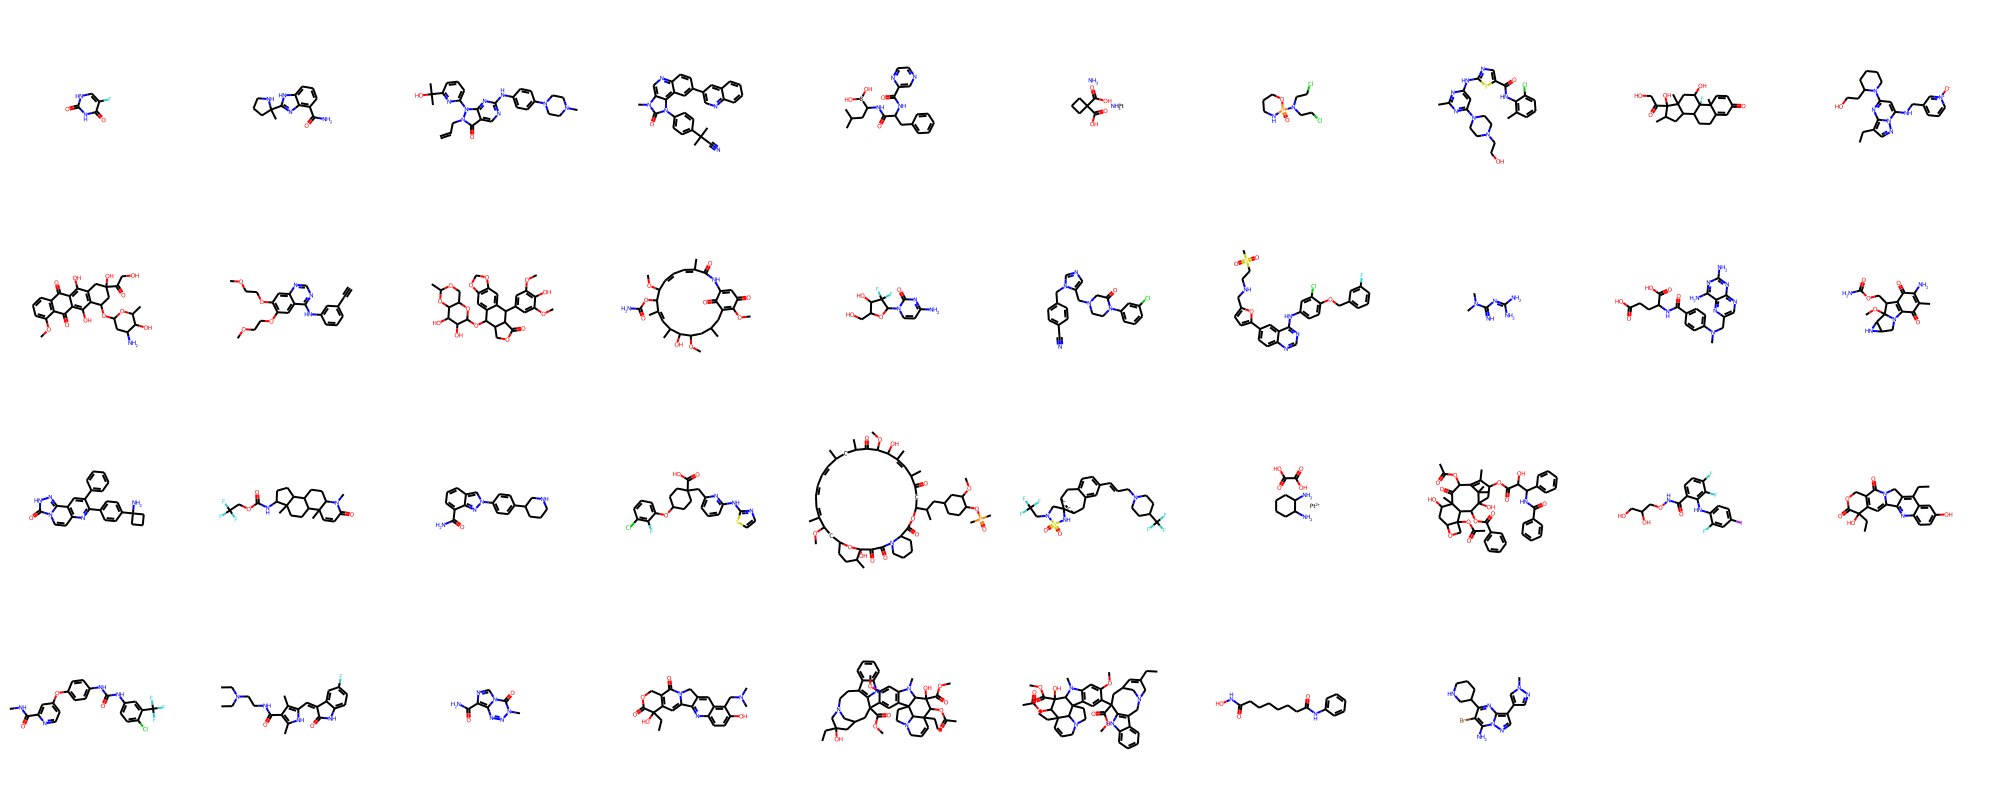

In [25]:
Draw.MolsToGridImage(uniq_mol.Mol.head(40), molsPerRow=10)

In [26]:
# num_drugs = len(uniq_mol)
# int((num_drugs * (num_drugs-1))/2)

In [27]:
# uniq_mol.iloc[0].Data

In [28]:
uniq_mol.iloc[0].DataOGB

Data(edge_index=[2, 18], edge_attr=[18, 3], x=[9, 9])

In [29]:
# zhang_labels = pd.read_csv(rawdata_dir + '/DS1/drug_drug_matrix_wids.csv').set_index('Unnamed: 0')
# y_df = zhang_labels

In [30]:
# %%time

# y_df = ReaderWriter.read_or_dump_data(file_name=norm_join_paths(targetdata_dir_raw, 'y_df.pkl'),
#                                      data_gen_fun = generate_labels_df,
#                                      data_gen_params=(uniq_mol, datashort))

In [31]:
# y_df = generate_labels_df(uniq_mol, data)

# ReaderWriter.dump_data(y_df, os.path.join(targetdata_dir_raw, 'y_df.pkl'))

#y_df = ReaderWriter.read_data(os.path.join(targetdata_dir_raw, 'y_df.pkl'))

In [32]:
# y_df

In [33]:
# y_df[y_df > 0] = 1
# y_df

In [34]:
# y = get_y_from_interactionmat(y_df.to_numpy())
# len(y)

In [35]:
binary_Y_threshold = 30

In [36]:
y = data.Y.copy()
y

0         7.693530
1         7.778053
2        -1.198505
3         2.595684
4        -5.139971
           ...    
23047    10.223066
23048    20.551627
23049    12.190316
23050    23.438547
23051    12.223791
Name: Y, Length: 23052, dtype: float64

In [37]:
str(round((len(y[y>=binary_Y_threshold]) / len(y) *100), 2)) + "% positive labels"

'9.03% positive labels'

<AxesSubplot:xlabel='Y'>

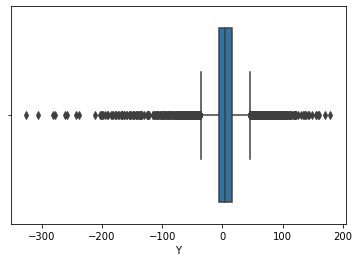

In [38]:
sns.boxplot(y)

In [39]:
positive_labels = y>=binary_Y_threshold
negative_labels = y<binary_Y_threshold

In [40]:
y[positive_labels] = 1
y[negative_labels] = 0
y = y.astype(int)
y

0        0
1        0
2        0
3        0
4        0
        ..
23047    0
23048    0
23049    0
23050    0
23051    0
Name: Y, Length: 23052, dtype: int64

In [41]:
y.values

array([0, 0, 0, ..., 0, 0, 0])

In [42]:
ReaderWriter.dump_data(y.values, os.path.join(targetdata_dir_raw, 'y.pkl'))

In [43]:
y_weights = compute_class_weights(torch.tensor(y))
y_weights

array([0.54961614, 5.53868333])

In [44]:
ReaderWriter.dump_data(y_weights, os.path.join(targetdata_dir_raw, 'y_weights.pkl'))

In [45]:
expression = data["Cell_Line"].values
expression

array([array([ 5.29114604,  5.04038672,  5.29114604, ...,  0.69189136,
              -0.9825026 , -0.36456493])                              ,
       array([ 5.29114604,  5.04038672,  5.29114604, ...,  1.13929333,
              -1.07020346, -0.42541529])                              ,
       array([ 5.29114604,  5.04038672,  5.29114604, ..., -0.42313671,
              -1.06511996, -1.00249025])                              ,
       ...,
       array([-0.18899497, -0.19839748, -0.18899497, ..., -0.37422676,
              -0.07355896, -0.21785647])                              ,
       array([-0.18899497, -0.19839748, -0.18899497, ..., -0.43659348,
               1.20746417, -1.52213641])                              ,
       array([-0.18899497, -0.19839748, -0.18899497, ..., -1.7055414 ,
              -0.71434724,  0.63526581])                              ],
      dtype=object)

In [46]:
ReaderWriter.dump_data(expression, os.path.join(targetdata_dir_raw, 'expression.pkl'))

In [47]:
# report_label_distrib(y)

In [48]:
# lasso_input_dim = 2*tp["emb_dim"]+1+expression_input_size
# lasso_out_dim = dataset.num_classes

# lassonet_model = LassoNet(lasso_input_dim, lasso_out_dim)# # pairs = list(itertools.combinations(uniq_mol.Drug_ID, 2))
# pairs = construct_sampleid_ddipairs(y_df.to_numpy())
# len(pairs)

In [49]:
pairs = {i:(row.Drug1_ID, row.Drug2_ID) for i, row in data.iterrows()}
len(pairs)

23052

In [66]:
# pairs

In [51]:
# pairs_sub = {k: pairs[k] for k in range(10)}
# pairs_sub

In [52]:
%%time

X = ReaderWriter.read_or_dump_data(file_name=norm_join_paths(targetdata_dir_raw, 'X.pkl'),
                              data_gen_fun=get_X_all_pairdata_synergy,
                              data_gen_params=(uniq_mol, pairs, "DataOGB"))

CPU times: user 311 ms, sys: 45 ms, total: 356 ms
Wall time: 356 ms


In [53]:
# X = get_X_all_pairdata(uniq_mol, pairs)

# ReaderWriter.dump_data(X, os.path.join(targetdata_dir_raw, 'X.pkl'))

#X = ReaderWriter.read_data(os.path.join(targetdata_dir_raw, 'X.pkl'))


In [68]:
# X

In [55]:
targetdata_dir

'/cluster/home/skyriakos/chemprop_run/git/data/processed/OncoPolyPharmacology/data_v1'

In [56]:
targetdata_dir_processed

'/cluster/home/skyriakos/chemprop_run/git/data/processed/OncoPolyPharmacology/data_v1/processed'

In [60]:
# import glob

# list_generated_files = glob.glob(targetdata_dir_processed + "/*")
# print(list_generated_files)

# for file in list_generated_files:
#     os.remove(file)

['/cluster/home/skyriakos/chemprop_run/git/data/processed/OncoPolyPharmacology/data_v1/processed/geometric_data_processed.pt', '/cluster/home/skyriakos/chemprop_run/git/data/processed/OncoPolyPharmacology/data_v1/processed/pre_transform.pt', '/cluster/home/skyriakos/chemprop_run/git/data/processed/OncoPolyPharmacology/data_v1/processed/pre_filter.pt', '/cluster/home/skyriakos/chemprop_run/git/data/processed/OncoPolyPharmacology/data_v1/processed/train.log', '/cluster/home/skyriakos/chemprop_run/git/data/processed/OncoPolyPharmacology/data_v1/processed/valid.log', '/cluster/home/skyriakos/chemprop_run/git/data/processed/OncoPolyPharmacology/data_v1/processed/test.log']


In [61]:
%%time

# In order to generate a new Dataset, first remove the generated files above

dataset = MoleculeDataset(root=targetdata_dir, dataset='tdcSynergy')

Processing...
Done!


CPU times: user 11.5 s, sys: 4.19 s, total: 15.7 s
Wall time: 16.7 s


In [62]:
print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data0 = dataset[0]  # Get the first graph object.

# print()
# print(data)
# print('=============================================================')

# # Gather some statistics about the first graph.
# print(f'Number of nodes: {data.num_nodes}')
# print(f'Number of edges: {data.num_edges}')
# print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
# print(f'Contains isolated nodes: {data.contains_isolated_nodes()}')
# print(f'Contains self-loops: {data.contains_self_loops()}')
# print(f'Is undirected: {data.is_undirected()}')


Dataset: MoleculeDataset(23052):
Number of graphs: 23052
Number of features: 9
Number of classes: 2


In [63]:
data0

PairData(edge_index_a=[2, 18], x_a=[9, 9], edge_attr_a=[18, 3], edge_index_b=[2, 40], x_b=[18, 9], edge_attr_b=[40, 3], id=[1], y=[1], expression=[1, 8785])

In [64]:
data0.expression.dtype

torch.float32

In [65]:
len(dataset)

23052

### SynergxDB dataset

In [14]:
dataset_names = list(pd.read_csv('../data/synergxdb/datasets_hot_encoding.csv', header=None)[0])
dataset_names

['MERCK',
 'NCI-ALMANAC',
 'YALE-PDAC',
 'YALE-TNBC',
 'CLOUD',
 'MIT-MELANOMA',
 'STANFORD',
 'DECREASE',
 'VISAGE']

In [15]:
df_drug_comb = pd.read_csv('../data/synergxdb/drug_combinations_all.txt', sep='\t')
df_drug_comb

,smilesDrugA,smilesDrugB,idSample,bliss,loewe,dataSet
0,CC12CCC3C(C1CCC2NC(=O)OCC(F)(F)F)CCC4C3(C=CC(=...,CC1=C(C(=O)C2=C(C1=O)N3CC4C(C3(C2COC(=O)N)OC)N4)N,25,-1.0773,-0.2243,[1. 0. 0. 0. 0. 0. 0. 0. 0.]
1,C1=CC=C(C=C1)NC(=O)CCCCCCC(=O)NO,C1CC(CCC1OC2=C(C(=CC=C2)Cl)F)(CC3=NC(=CC=C3)NC...,37,-1.0052,-0.0900,[1. 0. 0. 0. 0. 0. 0. 0. 0.]
2,CC(C)(C#N)C1=CC=C(C=C1)N2C3=C4C=C(C=CC4=NC=C3N...,CCC1=C2CN3C(=CC4=C(C3=O)COC(=O)C4(CC)O)C2=NC5=...,80,-1.1420,-0.4718,[1. 0. 0. 0. 0. 0. 0. 0. 0.]
3,COCCOC1=C(C=C2C(=C1)C(=NC=N2)NC3=CC=CC(=C3)C#C...,CC1(CCCN1)C2=NC3=C(C=CC=C3N2)C(=O)N,69,-0.7307,0.1504,[1. 0. 0. 0. 0. 0. 0. 0. 0.]
4,C1CN(C(=O)CN1CC2=CN=CN2CC3=CC=C(C=C3)C#N)C4=CC...,C1CC(CNC1)C2=CC=C(C=C2)N3C=C4C=CC=C(C4=N3)C(=O)N,85,-0.9707,-0.0021,[1. 0. 0. 0. 0. 0. 0. 0. 0.]
...,...,...,...,...,...,...
531974,C1CC1NC2=NC(=NC(=C2)C3=C(C(=CC=C3)Cl)Cl)N,CCC1C(=O)N(C2=CN=C(N=C2N1C3CCCC3)NC4=C(C=C(C=C...,28,-0.5230,0.0025,[0. 0. 0. 0. 0. 0. 0. 0. 1.]
531975,C1CC1NC2=NC(=NC(=C2)C3=C(C(=CC=C3)Cl)Cl)N,CCC1C(=O)N(C2=CN=C(N=C2N1C3CCCC3)NC4=C(C=C(C=C...,26,-0.5811,-0.0315,[0. 0. 0. 0. 0. 0. 0. 0. 1.]
531976,C1CC1NC2=NC(=NC(=C2)C3=C(C(=CC=C3)Cl)Cl)N,CCC1C(=O)N(C2=CN=C(N=C2N1C3CCCC3)NC4=C(C=C(C=C...,23,-0.5919,-0.0446,[0. 0. 0. 0. 0. 0. 0. 0. 1.]
531977,C1CC1NC2=NC(=NC(=C2)C3=C(C(=CC=C3)Cl)Cl)N,CCC1C(=O)N(C2=CN=C(N=C2N1C3CCCC3)NC4=C(C=C(C=C...,204,-0.5742,-0.3786,[0. 0. 0. 0. 0. 0. 0. 0. 1.]


In [16]:
df_drug_comb['dsVec'] = [ast.literal_eval(ds.replace(" ", ',')) for ds in df_drug_comb['dataSet']]
df_drug_comb

,smilesDrugA,smilesDrugB,idSample,bliss,loewe,dataSet,dsVec
0,CC12CCC3C(C1CCC2NC(=O)OCC(F)(F)F)CCC4C3(C=CC(=...,CC1=C(C(=O)C2=C(C1=O)N3CC4C(C3(C2COC(=O)N)OC)N4)N,25,-1.0773,-0.2243,[1. 0. 0. 0. 0. 0. 0. 0. 0.],"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
1,C1=CC=C(C=C1)NC(=O)CCCCCCC(=O)NO,C1CC(CCC1OC2=C(C(=CC=C2)Cl)F)(CC3=NC(=CC=C3)NC...,37,-1.0052,-0.0900,[1. 0. 0. 0. 0. 0. 0. 0. 0.],"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
2,CC(C)(C#N)C1=CC=C(C=C1)N2C3=C4C=C(C=CC4=NC=C3N...,CCC1=C2CN3C(=CC4=C(C3=O)COC(=O)C4(CC)O)C2=NC5=...,80,-1.1420,-0.4718,[1. 0. 0. 0. 0. 0. 0. 0. 0.],"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
3,COCCOC1=C(C=C2C(=C1)C(=NC=N2)NC3=CC=CC(=C3)C#C...,CC1(CCCN1)C2=NC3=C(C=CC=C3N2)C(=O)N,69,-0.7307,0.1504,[1. 0. 0. 0. 0. 0. 0. 0. 0.],"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
4,C1CN(C(=O)CN1CC2=CN=CN2CC3=CC=C(C=C3)C#N)C4=CC...,C1CC(CNC1)C2=CC=C(C=C2)N3C=C4C=CC=C(C4=N3)C(=O)N,85,-0.9707,-0.0021,[1. 0. 0. 0. 0. 0. 0. 0. 0.],"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
...,...,...,...,...,...,...,...
531974,C1CC1NC2=NC(=NC(=C2)C3=C(C(=CC=C3)Cl)Cl)N,CCC1C(=O)N(C2=CN=C(N=C2N1C3CCCC3)NC4=C(C=C(C=C...,28,-0.5230,0.0025,[0. 0. 0. 0. 0. 0. 0. 0. 1.],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]"
531975,C1CC1NC2=NC(=NC(=C2)C3=C(C(=CC=C3)Cl)Cl)N,CCC1C(=O)N(C2=CN=C(N=C2N1C3CCCC3)NC4=C(C=C(C=C...,26,-0.5811,-0.0315,[0. 0. 0. 0. 0. 0. 0. 0. 1.],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]"
531976,C1CC1NC2=NC(=NC(=C2)C3=C(C(=CC=C3)Cl)Cl)N,CCC1C(=O)N(C2=CN=C(N=C2N1C3CCCC3)NC4=C(C=C(C=C...,23,-0.5919,-0.0446,[0. 0. 0. 0. 0. 0. 0. 0. 1.],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]"
531977,C1CC1NC2=NC(=NC(=C2)C3=C(C(=CC=C3)Cl)Cl)N,CCC1C(=O)N(C2=CN=C(N=C2N1C3CCCC3)NC4=C(C=C(C=C...,204,-0.5742,-0.3786,[0. 0. 0. 0. 0. 0. 0. 0. 1.],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]"


In [17]:
df_drug_comb.columns

Index(['smilesDrugA', 'smilesDrugB', 'idSample', 'bliss', 'loewe', 'dataSet',
       'dsVec'],
      dtype='object')

In [18]:
datasets_1hot = pd.DataFrame(data=np.stack(df_drug_comb['dsVec']), columns=dataset_names)
datasets_1hot

,MERCK,NCI-ALMANAC,YALE-PDAC,YALE-TNBC,CLOUD,MIT-MELANOMA,STANFORD,DECREASE,VISAGE
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
531974,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
531975,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
531976,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
531977,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [19]:
df_drug_comb_1hot = pd.concat([df_drug_comb[['smilesDrugA', 'smilesDrugB', 'idSample', 'bliss', 'loewe']], datasets_1hot], axis=1)
df_drug_comb_1hot

,smilesDrugA,smilesDrugB,idSample,bliss,loewe,MERCK,NCI-ALMANAC,YALE-PDAC,YALE-TNBC,CLOUD,MIT-MELANOMA,STANFORD,DECREASE,VISAGE
0,CC12CCC3C(C1CCC2NC(=O)OCC(F)(F)F)CCC4C3(C=CC(=...,CC1=C(C(=O)C2=C(C1=O)N3CC4C(C3(C2COC(=O)N)OC)N4)N,25,-1.0773,-0.2243,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,C1=CC=C(C=C1)NC(=O)CCCCCCC(=O)NO,C1CC(CCC1OC2=C(C(=CC=C2)Cl)F)(CC3=NC(=CC=C3)NC...,37,-1.0052,-0.0900,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,CC(C)(C#N)C1=CC=C(C=C1)N2C3=C4C=C(C=CC4=NC=C3N...,CCC1=C2CN3C(=CC4=C(C3=O)COC(=O)C4(CC)O)C2=NC5=...,80,-1.1420,-0.4718,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,COCCOC1=C(C=C2C(=C1)C(=NC=N2)NC3=CC=CC(=C3)C#C...,CC1(CCCN1)C2=NC3=C(C=CC=C3N2)C(=O)N,69,-0.7307,0.1504,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,C1CN(C(=O)CN1CC2=CN=CN2CC3=CC=C(C=C3)C#N)C4=CC...,C1CC(CNC1)C2=CC=C(C=C2)N3C=C4C=CC=C(C4=N3)C(=O)N,85,-0.9707,-0.0021,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
531974,C1CC1NC2=NC(=NC(=C2)C3=C(C(=CC=C3)Cl)Cl)N,CCC1C(=O)N(C2=CN=C(N=C2N1C3CCCC3)NC4=C(C=C(C=C...,28,-0.5230,0.0025,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
531975,C1CC1NC2=NC(=NC(=C2)C3=C(C(=CC=C3)Cl)Cl)N,CCC1C(=O)N(C2=CN=C(N=C2N1C3CCCC3)NC4=C(C=C(C=C...,26,-0.5811,-0.0315,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
531976,C1CC1NC2=NC(=NC(=C2)C3=C(C(=CC=C3)Cl)Cl)N,CCC1C(=O)N(C2=CN=C(N=C2N1C3CCCC3)NC4=C(C=C(C=C...,23,-0.5919,-0.0446,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
531977,C1CC1NC2=NC(=NC(=C2)C3=C(C(=CC=C3)Cl)Cl)N,CCC1C(=O)N(C2=CN=C(N=C2N1C3CCCC3)NC4=C(C=C(C=C...,204,-0.5742,-0.3786,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [20]:
df_drug_comb_1hot.to_csv('../data/synergxdb/drug_combinations_1hot_KS.tsv', sep='\t', index=False)

In [21]:
df_drug_comb_1hot[dataset_names].sum()

MERCK            22717.0
NCI-ALMANAC     296720.0
YALE-PDAC         3326.0
YALE-TNBC         4573.0
CLOUD             1327.0
MIT-MELANOMA    201254.0
STANFORD          1818.0
DECREASE           210.0
VISAGE              34.0
dtype: float64

In [22]:
df_drug_comb_1hot[dataset_names].sum(axis=1).value_counts()

1.0    531979
dtype: int64

In [23]:
melt = df_drug_comb_1hot[dataset_names].melt()
meltvar = melt[melt.value==1.0].variable
meltvar.index

Int64Index([      0,       1,       2,       3,       4,       5,       6,
                  7,       8,       9,
            ...
            4787801, 4787802, 4787803, 4787804, 4787805, 4787806, 4787807,
            4787808, 4787809, 4787810],
           dtype='int64', length=531979)

In [24]:
df_drug_comb_1hot['dsName'] = list(melt[melt.value==1.0].variable)
df_drug_comb_1hot

,smilesDrugA,smilesDrugB,idSample,bliss,loewe,MERCK,NCI-ALMANAC,YALE-PDAC,YALE-TNBC,CLOUD,MIT-MELANOMA,STANFORD,DECREASE,VISAGE,dsName
0,CC12CCC3C(C1CCC2NC(=O)OCC(F)(F)F)CCC4C3(C=CC(=...,CC1=C(C(=O)C2=C(C1=O)N3CC4C(C3(C2COC(=O)N)OC)N4)N,25,-1.0773,-0.2243,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MERCK
1,C1=CC=C(C=C1)NC(=O)CCCCCCC(=O)NO,C1CC(CCC1OC2=C(C(=CC=C2)Cl)F)(CC3=NC(=CC=C3)NC...,37,-1.0052,-0.0900,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MERCK
2,CC(C)(C#N)C1=CC=C(C=C1)N2C3=C4C=C(C=CC4=NC=C3N...,CCC1=C2CN3C(=CC4=C(C3=O)COC(=O)C4(CC)O)C2=NC5=...,80,-1.1420,-0.4718,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MERCK
3,COCCOC1=C(C=C2C(=C1)C(=NC=N2)NC3=CC=CC(=C3)C#C...,CC1(CCCN1)C2=NC3=C(C=CC=C3N2)C(=O)N,69,-0.7307,0.1504,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MERCK
4,C1CN(C(=O)CN1CC2=CN=CN2CC3=CC=C(C=C3)C#N)C4=CC...,C1CC(CNC1)C2=CC=C(C=C2)N3C=C4C=CC=C(C4=N3)C(=O)N,85,-0.9707,-0.0021,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MERCK
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
531974,C1CC1NC2=NC(=NC(=C2)C3=C(C(=CC=C3)Cl)Cl)N,CCC1C(=O)N(C2=CN=C(N=C2N1C3CCCC3)NC4=C(C=C(C=C...,28,-0.5230,0.0025,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,VISAGE
531975,C1CC1NC2=NC(=NC(=C2)C3=C(C(=CC=C3)Cl)Cl)N,CCC1C(=O)N(C2=CN=C(N=C2N1C3CCCC3)NC4=C(C=C(C=C...,26,-0.5811,-0.0315,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,VISAGE
531976,C1CC1NC2=NC(=NC(=C2)C3=C(C(=CC=C3)Cl)Cl)N,CCC1C(=O)N(C2=CN=C(N=C2N1C3CCCC3)NC4=C(C=C(C=C...,23,-0.5919,-0.0446,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,VISAGE
531977,C1CC1NC2=NC(=NC(=C2)C3=C(C(=CC=C3)Cl)Cl)N,CCC1C(=O)N(C2=CN=C(N=C2N1C3CCCC3)NC4=C(C=C(C=C...,204,-0.5742,-0.3786,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,VISAGE


In [25]:
len(set(df_drug_comb_1hot.idSample))

150

In [26]:
merck = df_drug_comb_1hot[df_drug_comb_1hot.MERCK == 1.0]
merck

,smilesDrugA,smilesDrugB,idSample,bliss,loewe,MERCK,NCI-ALMANAC,YALE-PDAC,YALE-TNBC,CLOUD,MIT-MELANOMA,STANFORD,DECREASE,VISAGE,dsName
0,CC12CCC3C(C1CCC2NC(=O)OCC(F)(F)F)CCC4C3(C=CC(=...,CC1=C(C(=O)C2=C(C1=O)N3CC4C(C3(C2COC(=O)N)OC)N4)N,25,-1.0773,-0.2243,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MERCK
1,C1=CC=C(C=C1)NC(=O)CCCCCCC(=O)NO,C1CC(CCC1OC2=C(C(=CC=C2)Cl)F)(CC3=NC(=CC=C3)NC...,37,-1.0052,-0.0900,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MERCK
2,CC(C)(C#N)C1=CC=C(C=C1)N2C3=C4C=C(C=CC4=NC=C3N...,CCC1=C2CN3C(=CC4=C(C3=O)COC(=O)C4(CC)O)C2=NC5=...,80,-1.1420,-0.4718,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MERCK
3,COCCOC1=C(C=C2C(=C1)C(=NC=N2)NC3=CC=CC(=C3)C#C...,CC1(CCCN1)C2=NC3=C(C=CC=C3N2)C(=O)N,69,-0.7307,0.1504,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MERCK
4,C1CN(C(=O)CN1CC2=CN=CN2CC3=CC=C(C=C3)C#N)C4=CC...,C1CC(CNC1)C2=CC=C(C=C2)N3C=C4C=CC=C(C4=N3)C(=O)N,85,-0.9707,-0.0021,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MERCK
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22712,CC12CCC3C(C1CCC2NC(=O)OCC(F)(F)F)CCC4C3(C=CC(=...,CN(C)C(=N)N=C(N)N,59,-0.0736,0.0682,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MERCK
22713,C1CC(CCC1OC2=C(C(=CC=C2)Cl)F)(CC3=NC(=CC=C3)NC...,C1CC(CNC1)C2=CC=C(C=C2)N3C=C4C=CC=C(C4=N3)C(=O)N,25,-0.5037,0.2095,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MERCK
22714,CCC1(CC2CC(C3=C(CCN(C2)C1)C4=CC=CC=C4N3)(C5=C(...,C1CC(CNC1)C2=CC=C(C=C2)N3C=C4C=CC=C(C4=N3)C(=O)N,80,-0.3817,0.3014,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MERCK
22715,CC(C)(C#N)C1=CC=C(C=C1)N2C3=C4C=C(C=CC4=NC=C3N...,CN1C=C(C=N1)C2=C3N=C(C(=C(N3N=C2)N)Br)C4CCCNC4,28,-0.6611,-0.0184,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MERCK


<AxesSubplot:xlabel='loewe', ylabel='Count'>

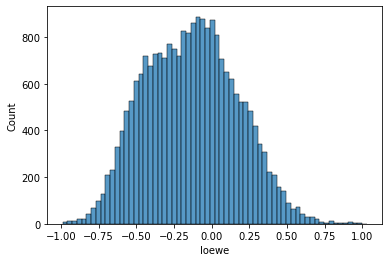

In [27]:
sns.histplot(merck.loewe)

<AxesSubplot:xlabel='bliss', ylabel='Count'>

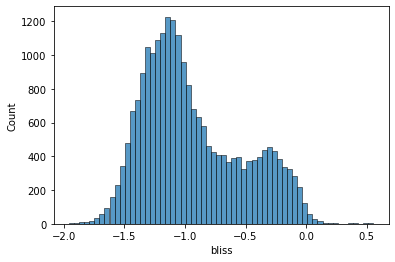

In [28]:
sns.histplot(merck.bliss)

(-2.0, 2.0)

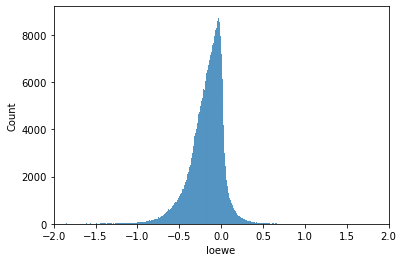

In [29]:
ax = sns.histplot(df_drug_comb_1hot.loewe)
ax.set_xlim(-2, 2)

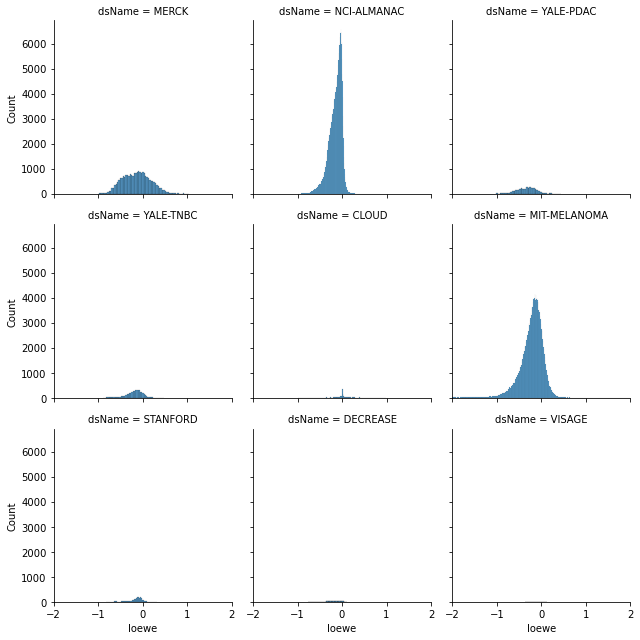

In [30]:
g = sns.FacetGrid(df_drug_comb_1hot, col="dsName", col_wrap=3, xlim=(-2, 2))
g.map(sns.histplot, "loewe")

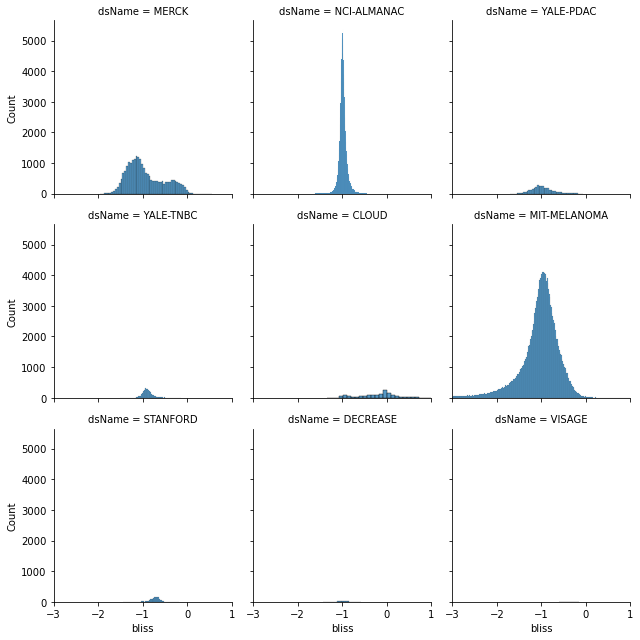

In [31]:
g = sns.FacetGrid(df_drug_comb_1hot, col="dsName", col_wrap=3, xlim=(-3, 1))
g.map(sns.histplot, "bliss")

In [32]:
set(df_drug_comb_1hot.idSample)

{1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 94,
 96,
 116,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,
 185,
 186,
 187,
 188,
 189,
 190,
 191,
 192,
 193,
 194,
 195,
 196,
 197,
 198,
 199,
 200,
 201,
 202,
 203,
 204,
 205,
 206,
 207,
 208,
 209,
 210,
 211,
 212,
 213}

In [33]:
df_mol_data_zscored = pd.read_csv('../data/synergxdb/molecular_data_zscored.csv')
df_mol_data_zscored

,Unnamed: 0,idSample,name,hgnc_symbol,fpkm,zscore
0,0,1,K-562,A1BG,0,-0.055465
1,1,1,K-562,A1BG-AS1,0,-0.055465
2,2,1,K-562,A1CF,0,-0.055465
3,3,1,K-562,A2M,0,-0.055465
4,4,1,K-562,A2M-AS1,0,-0.055465
...,...,...,...,...,...,...
3814123,3814123,186,T98G,ZYG11B,5,-0.019784
3814124,3814124,186,T98G,ZYX,48,0.287076
3814125,3814125,186,T98G,ZYXP1,0,-0.055465
3814126,3814126,186,T98G,ZZEF1,6,-0.012647


In [34]:
len(set(df_mol_data_zscored.name))

94

In [35]:
set(df_mol_data_zscored.idSample)

{1,
 2,
 3,
 4,
 6,
 7,
 8,
 9,
 10,
 11,
 13,
 14,
 15,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 37,
 38,
 39,
 40,
 41,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 82,
 83,
 84,
 85,
 86,
 87,
 89,
 90,
 94,
 96,
 116,
 156,
 157,
 159,
 163,
 164,
 166,
 167,
 168,
 169,
 170,
 173,
 174,
 177,
 178,
 186}

In [36]:
set(df_drug_comb_1hot.idSample).difference(set(df_mol_data_zscored.idSample))

{5,
 12,
 16,
 17,
 18,
 19,
 27,
 36,
 42,
 43,
 44,
 58,
 81,
 88,
 158,
 160,
 161,
 162,
 165,
 171,
 172,
 175,
 176,
 179,
 180,
 181,
 182,
 183,
 184,
 185,
 187,
 188,
 189,
 190,
 191,
 192,
 193,
 194,
 195,
 196,
 197,
 198,
 199,
 200,
 201,
 202,
 203,
 204,
 205,
 206,
 207,
 208,
 209,
 210,
 211,
 212,
 213}